# Report: Investigating Network Compromise

### Executive Summary
This report details the findings of a comprehensive investigation into a network compromise. By establishing a behavioral baseline from normal traffic (`data10.parquet`) and comparing it against anomalous traffic logs (`test10.parquet` and `servers10.parquet`), we successfully identified and characterized a sophisticated attack involving both internal and external threats.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import folium
import pycountry
from tabulate import tabulate
from matplotlib.lines import Line2D

from analysis import UltimateSIEM, CRITICAL_COMBO_MULTIPLIER, ANOMALOUS_TIMING_STD_DEV_THRESHOLD

TOP_N_SUSPECTS_TO_PLOT = 10
MIN_SCORE_TO_PLOT = 40 
MIN_BYTES_TO_PLOT_INTERNAL = 5_000_000
TOP_N_EXTERNAL_PLOT = 15

plt.style.use('seaborn-v0_8-whitegrid')

BASELINE_PATH = './datasets/dataset10/data10.parquet'
ANOMALOUS_PATH = './datasets/dataset10/test10.parquet'
SERVERS_PATH = './datasets/dataset10/servers10.parquet'
GEOIP_DB_PATH = './datasets/GeoLite2-Country.mmdb'

In [3]:
def load_data(baseline_path, anomalous_path, servers_path):
    """Loads and prepares the primary datasets from Parquet files."""
    print("Loading and preparing datasets...")
    try:
        baseline_df = pd.read_parquet(baseline_path)
        anomalous_df = pd.read_parquet(anomalous_path)
        servers_df = pd.read_parquet(servers_path)
        for df in [baseline_df, anomalous_df, servers_df]:
            df['timestamp_sec'] = pd.to_datetime(df['timestamp'], unit='s')
        return baseline_df, anomalous_df, servers_df
    except FileNotFoundError as e:
        print(f"ERROR: Error loading data: {e}. Please check file paths.")
        return None, None, None

In [4]:
baseline_df, anomalous_df, servers_df = load_data(BASELINE_PATH, ANOMALOUS_PATH, SERVERS_PATH)

print("\n--- Baseline Data Head ---")
display(baseline_df.head())
print("\n--- Anomalous Data Head ---")
display(anomalous_df.head())
print("\n--- Servers Data Head ---")
display(servers_df.head())

Loading and preparing datasets...

--- Baseline Data Head ---


timestamp          src_ip           dst_ip proto  port  up_bytes  \
index                                                                      
906294    1584229  192.168.110.18  192.168.110.234   udp    53       177   
906295    1584303  192.168.110.18   142.250.184.14   tcp   443     20045   
906296    1584406  192.168.110.18   142.250.184.14   tcp   443      9905   
906297    1584519  192.168.110.18  157.240.212.174   tcp   443     12338   
906298    1584672  192.168.110.18  157.240.212.174   tcp   443      7107   

        down_bytes       timestamp_sec  
index                                   
906294         488 1970-01-19 08:03:49  
906295      140598 1970-01-19 08:05:03  
906296      108825 1970-01-19 08:06:46  
906297      121487 1970-01-19 08:08:39  
906298       67234 1970-01-19 08:11:12


--- Anomalous Data Head ---


timestamp          src_ip          dst_ip proto  port  up_bytes  \
index                                                                     
258181    1358158  192.168.110.23  193.137.20.123   tcp   443      6879   
258182    1358304  192.168.110.23  193.137.20.123   tcp   443     14289   
258183    1358349  192.168.110.23  193.137.20.123   tcp   443      6266   
258184    1358448  192.168.110.23  193.137.20.123   tcp   443      9094   
258185    1358565  192.168.110.23  193.137.20.123   tcp   443     10287   

        down_bytes       timestamp_sec  
index                                   
258181       59911 1970-01-16 17:15:58  
258182       97716 1970-01-16 17:18:24  
258183       43201 1970-01-16 17:19:09  
258184       85616 1970-01-16 17:20:48  
258185      100885 1970-01-16 17:22:45


--- Servers Data Head ---


timestamp        src_ip      dst_ip proto  port  up_bytes  down_bytes  \
index                                                                           
452139    1206712  176.223.2.64  200.0.0.11   tcp   443      5320       59230   
452140    1206794  176.223.2.64  200.0.0.11   tcp   443      8398       64349   
452141    1206880  176.223.2.64  200.0.0.11   tcp   443      8002       61415   
452142    1207016  176.223.2.64  200.0.0.11   tcp   443     16252      173706   
452143    1207094  176.223.2.64  200.0.0.11   tcp   443     11618       99295   

             timestamp_sec  
index                       
452139 1970-01-14 23:11:52  
452140 1970-01-14 23:13:14  
452141 1970-01-14 23:14:40  
452142 1970-01-14 23:16:56  
452143 1970-01-14 23:18:14

In [5]:
siem = UltimateSIEM(
    baseline_path=BASELINE_PATH,
    anomalous_path=ANOMALOUS_PATH,
    servers_path=SERVERS_PATH,
    geoip_db_path=GEOIP_DB_PATH
)
siem.run_full_analysis()

2025-07-06 22:50:14,763 - INFO - Loading datasets...
2025-07-06 22:50:15,380 - INFO - GeoIP database loaded successfully.
2025-07-06 22:50:15,381 - INFO - Identifying internal-only servers based on traffic directionality.
2025-07-06 22:50:52,460 - INFO - Identified 6 potential internal-only servers: ['192.168.110.234', '192.168.110.231', '192.168.110.235', '192.168.110.230', '192.168.110.238', '192.168.110.224']
2025-07-06 22:50:52,540 - INFO - Profiling identified internal servers by port usage...
2025-07-06 22:50:52,638 - INFO -   - Server 192.168.110.234 profiled as: DNS
2025-07-06 22:50:52,724 - INFO -   - Server 192.168.110.231 profiled as: HTTPS
2025-07-06 22:50:52,804 - INFO -   - Server 192.168.110.235 profiled as: HTTPS
2025-07-06 22:50:52,897 - INFO -   - Server 192.168.110.230 profiled as: DNS
2025-07-06 22:50:52,970 - INFO -   - Server 192.168.110.238 profiled as: HTTPS
2025-07-06 22:50:53,044 - INFO -   - Server 192.168.110.224 profiled as: HTTPS
2025-07-06 22:50:53,045 - 

### Baseline Traffic Profiling
Before searching for anomalies, we first establish a profile of the network's normal operational state.

**Data Volume**: The baseline shows that internal users are primarily data consumers, with an average download volume (0.09 MB) far exceeding the average upload volume (0.01 MB). A significant deviation from this pattern is a key indicator of anomalous activity.

In [40]:

print("\n" + "="*80 + "\n")

avg_upload_bytes = siem.baseline_df['up_bytes'].mean()
avg_download_bytes = siem.baseline_df['down_bytes'].mean()
avg_upload_mb = avg_upload_bytes / 1e6
avg_download_mb = avg_download_bytes / 1e6

print(f"Data Volume: The average upload per flow was {avg_upload_mb:.2f} MB, and the average download was {avg_download_mb:.2f} MB.")
print("\n" + "="*80)



Data Volume: The average upload per flow was 0.01 MB, and the average download was 0.09 MB.



#### Protocol and Port Distribution: Baseline vs Anomalous
A fundamental step is to compare protocol usage between the normal and anomalous periods.

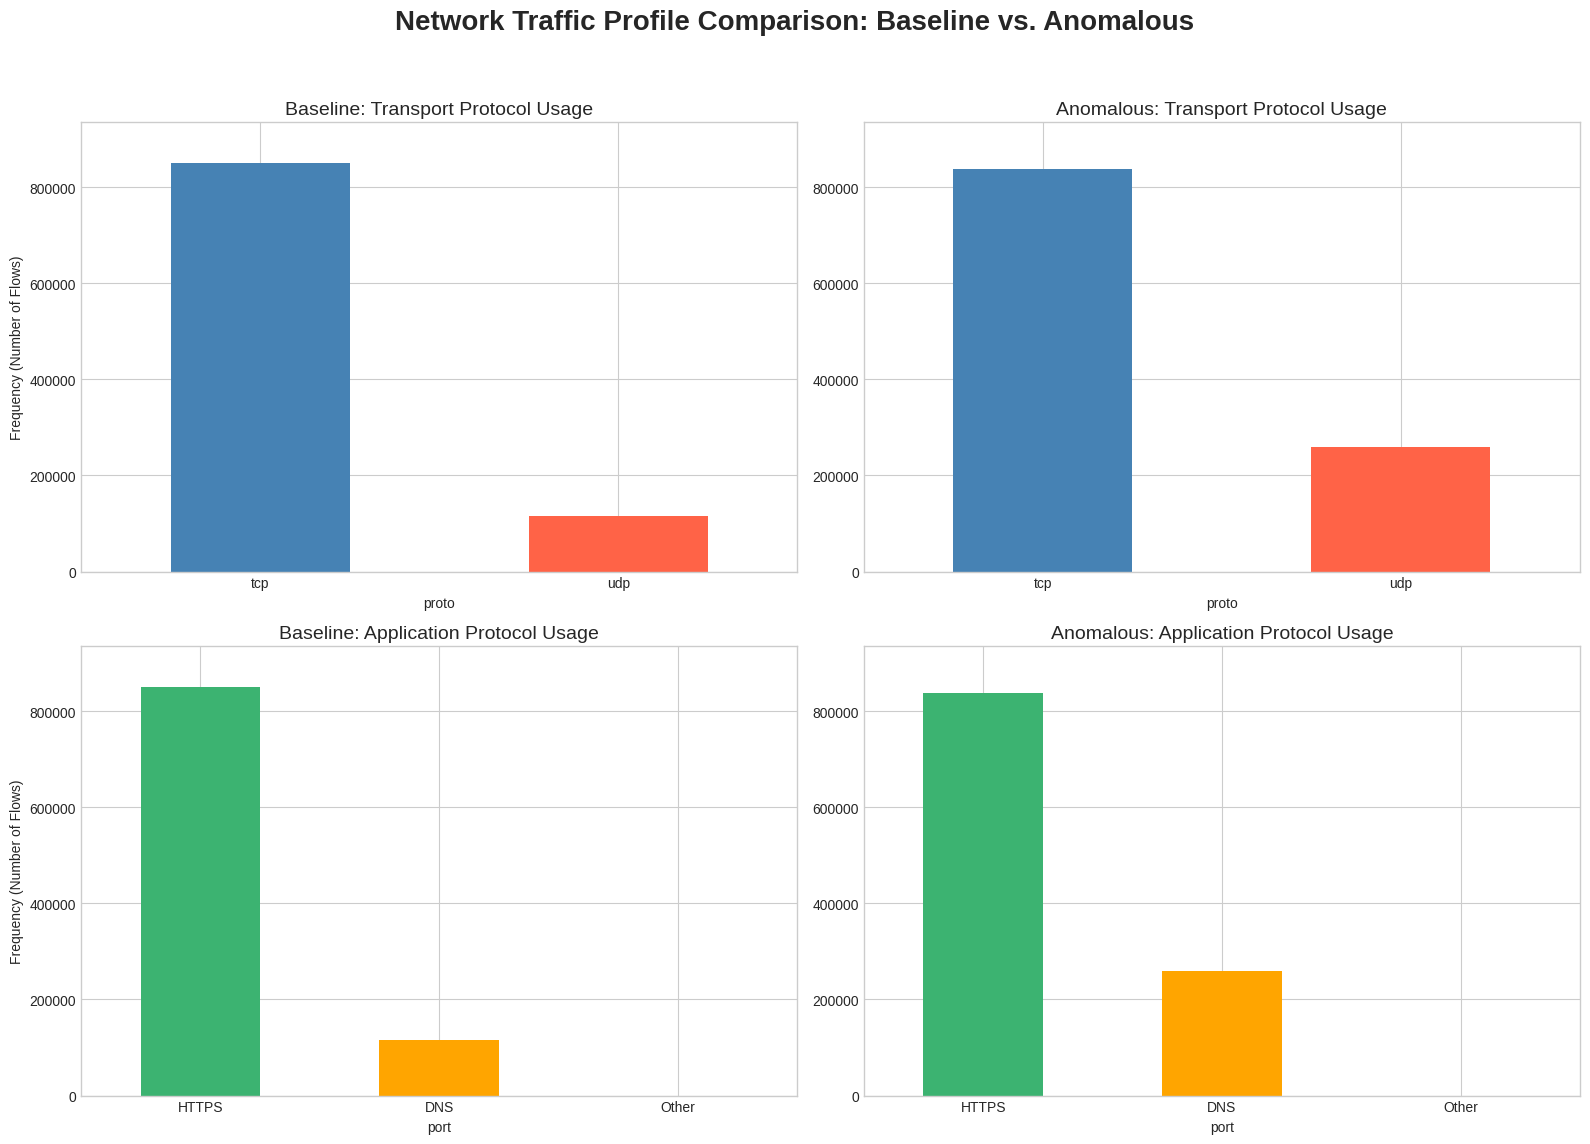

In [7]:
def plot_traffic_profile_comparison(siem):
    """
    Creates a 2x2 plot comparing protocol and port distributions between datasets.
    """
    if siem.baseline_protocol_counts is None:
        print("Network profile data not available. Skipping plot.")
        return

    protocol_order = ['tcp', 'udp']
    port_order = ['HTTPS', 'DNS', 'Other']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Network Traffic Profile Comparison: Baseline vs. Anomalous', fontsize=20, fontweight='bold')

    baseline_proto = siem.baseline_protocol_counts.reindex(protocol_order, fill_value=0)
    anomalous_proto = siem.anomalous_protocol_counts.reindex(protocol_order, fill_value=0)
    
    baseline_proto.plot(kind='bar', ax=axes[0, 0], color=['#4682b4', '#ff6347'])
    axes[0, 0].set_title('Baseline: Transport Protocol Usage', fontsize=14)
    axes[0, 0].set_ylabel('Frequency (Number of Flows)')
    axes[0, 0].tick_params(axis='x', rotation=0)

    anomalous_proto.plot(kind='bar', ax=axes[0, 1], color=['#4682b4', '#ff6347'])
    axes[0, 1].set_title('Anomalous: Transport Protocol Usage', fontsize=14)
    axes[0, 1].tick_params(axis='x', rotation=0)
    
    max_y_proto = max(baseline_proto.max(), anomalous_proto.max()) * 1.1
    axes[0, 0].set_ylim(0, max_y_proto)
    axes[0, 1].set_ylim(0, max_y_proto)

    baseline_ports = siem.baseline_port_counts.reindex(port_order, fill_value=0)
    anomalous_ports = siem.anomalous_port_counts.reindex(port_order, fill_value=0)

    baseline_ports.plot(kind='bar', ax=axes[1, 0], color=['#3cb371', '#ffa500', '#d3d3d3'])
    axes[1, 0].set_title('Baseline: Application Protocol Usage', fontsize=14)
    axes[1, 0].set_ylabel('Frequency (Number of Flows)')
    axes[1, 0].tick_params(axis='x', rotation=0)

    anomalous_ports.plot(kind='bar', ax=axes[1, 1], color=['#3cb371', '#ffa500', '#d3d3d3'])
    axes[1, 1].set_title('Anomalous: Application Protocol Usage', fontsize=14)
    axes[1, 1].tick_params(axis='x', rotation=0)

    max_y_port = max(baseline_ports.max(), anomalous_ports.max()) * 1.1
    axes[1, 0].set_ylim(0, max_y_port)
    axes[1, 1].set_ylim(0, max_y_port)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_traffic_profile_comparison(siem)

The anomalous dataset shows a significant increase in both UDP and DNS traffic. While initial analysis pointed to potential DNS tunneling, a deeper look at the upload/download ratios revealed that compromised hosts were receiving large payloads via DNS, indicating its use as a **Command & Control (C&C)** channel.

#### Internal Server Topology

To understand the internal network architecture, we identify which hosts act as dedicated servers. The graph below shows these servers and their top clients, with each server labeled by its profiled role (DNS, HTTPS). This map provides crucial context for distinguishing legitimate client-server traffic from suspicious peer-to-peer communication.

Graphing topology for 6 identified servers, showing top 5 clients for each.


/tmp/ipykernel_35143/3597394866.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_connections_df = aggregated_traffic.groupby('dst_ip').apply(
/tmp/ipykernel_35143/3597394866.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_servers)


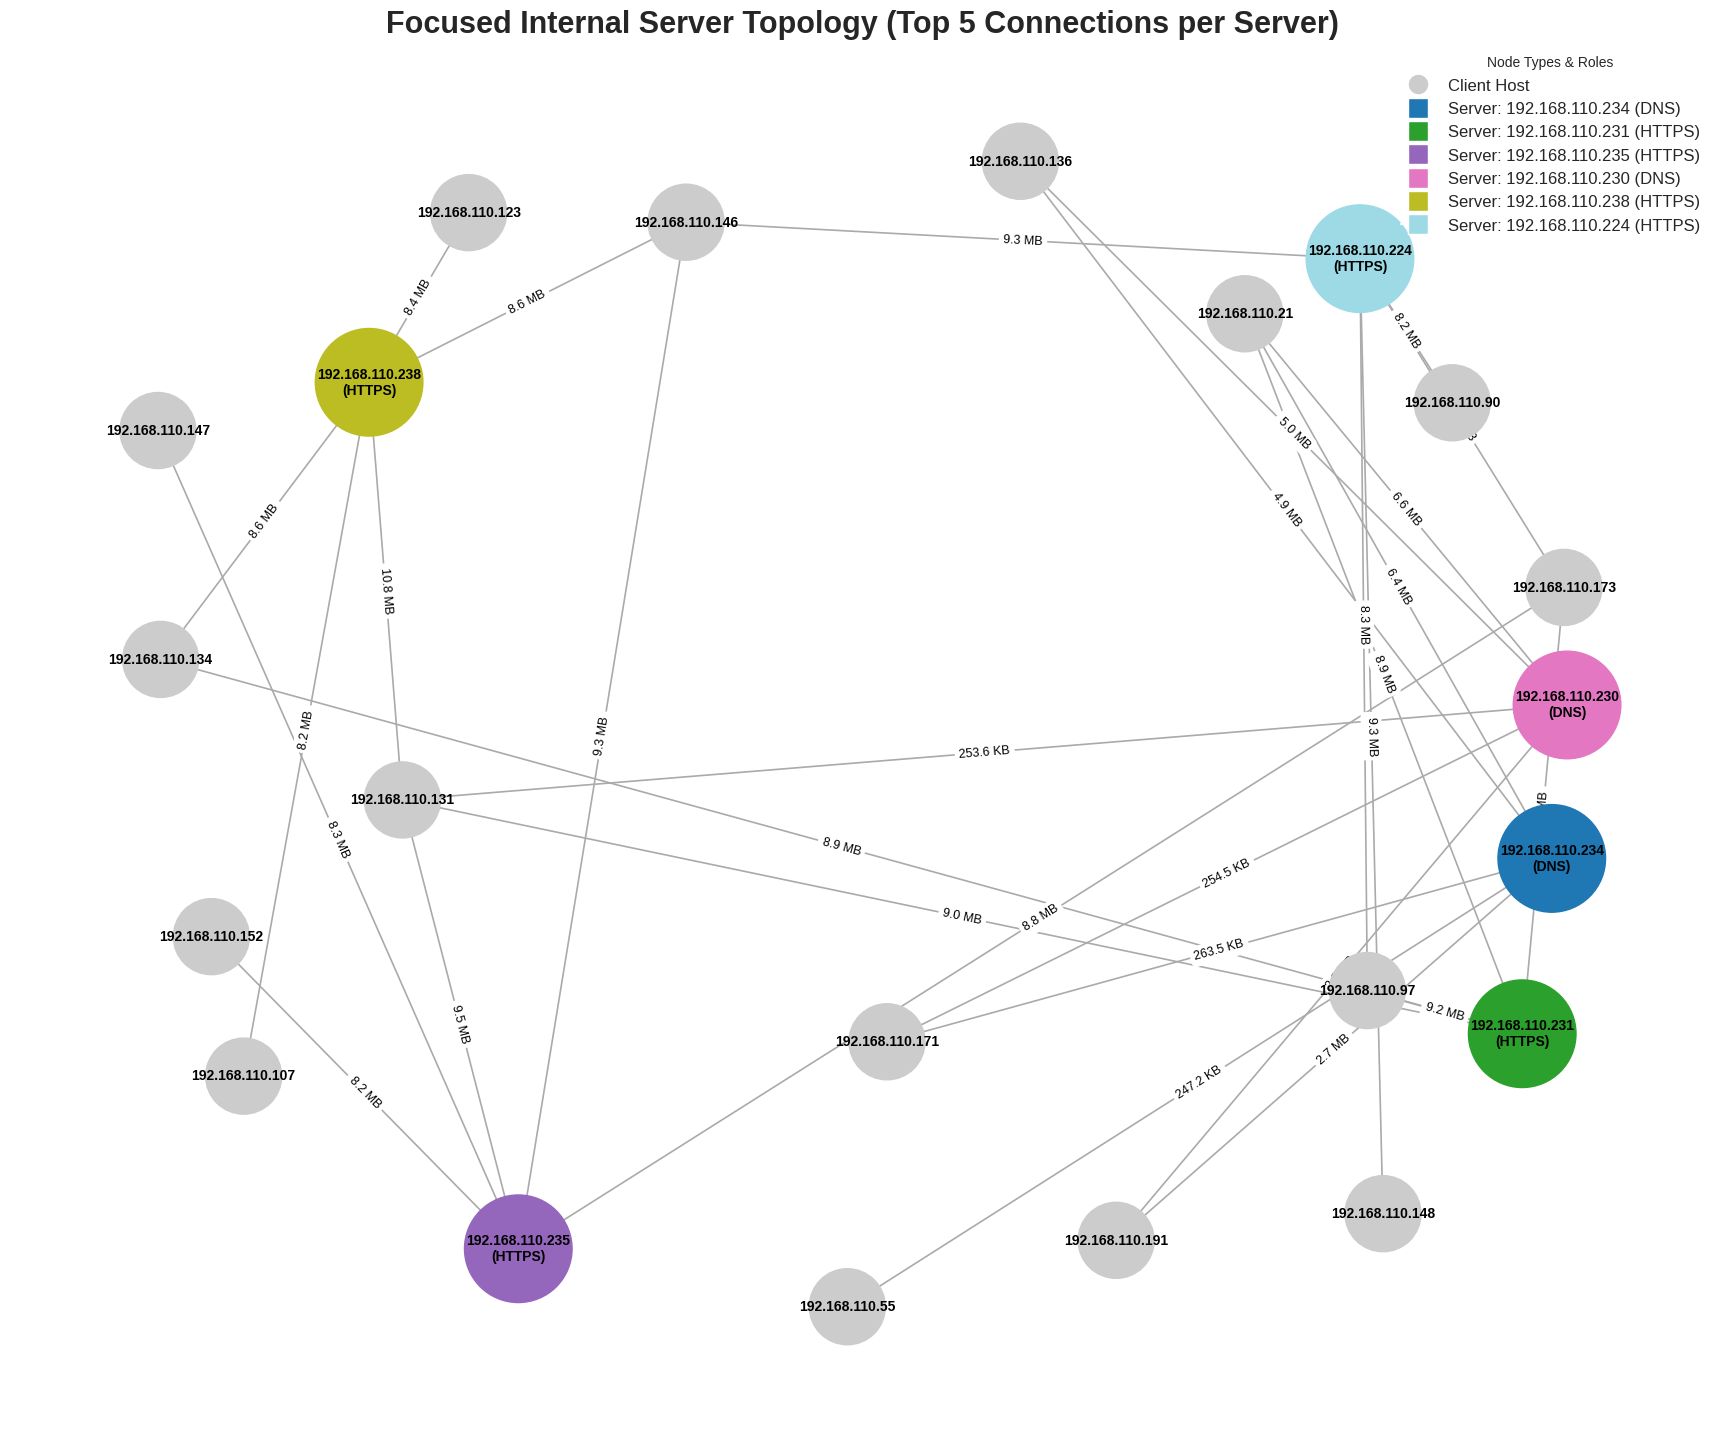

In [8]:
def plot_internal_server_topology(siem, top_n_clients=5):
    """
    Generates a focused graph of internal servers, showing top N clients for each.
    """
    if siem.internal_server_traffic.empty or not siem.identified_servers:
        print("No internal server topology to plot.")
        return

    print(f"Graphing topology for {len(siem.identified_servers)} identified servers, showing top {top_n_clients} clients for each.")

    aggregated_traffic = siem.internal_server_traffic.groupby(['dst_ip', 'src_ip']).agg(
        total_bytes=('up_bytes', 'sum')
    ).reset_index()

    top_connections_df = aggregated_traffic.groupby('dst_ip').apply(
        lambda x: x.nlargest(top_n_clients, 'total_bytes')
    ).reset_index(drop=True)

    if top_connections_df.empty:
        print("Could not find any connections to plot after filtering.")
        return

    G = nx.from_pandas_edgelist(
        top_connections_df,
        source='src_ip',
        target='dst_ip',
        edge_attr=['total_bytes'],
        create_using=nx.DiGraph()
    )

    plt.figure(figsize=(22, 18))
    pos = nx.spring_layout(G, k=2.0, iterations=50)

    server_nodes = siem.identified_servers
    num_servers = len(server_nodes)
    color_palette = plt.cm.get_cmap('tab20', num_servers)
    server_color_map = {ip: color_palette(i) for i, ip in enumerate(server_nodes)}
    
    client_color = '#cccccc'
    node_colors = [server_color_map.get(node, client_color) for node in G.nodes()]
    node_shapes = ['s' if node in server_nodes else 'o' for node in G.nodes()]
    node_sizes = [6000 if node in server_nodes else 3000 for node in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, width=1.2, edge_color='#aaaaaa', arrowsize=20, arrowstyle='->')

    node_labels = {}
    for node in G.nodes():
        if node in server_nodes:
            profile = siem.server_profiles.get(node, 'Unknown Role')
            node_labels[node] = f"{node}\n({profile})"
        else:
            node_labels[node] = node
            
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold')

    edge_labels = {
        (u, v): siem._format_bytes(d['total_bytes'])
        for u, v, d in G.edges(data=True) if d.get('total_bytes', 0) > 1000
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=9)

    plt.title(f'Focused Internal Server Topology (Top {top_n_clients} Connections per Server)', fontsize=22, fontweight='bold')
    plt.axis('off')

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Client Host',
               markerfacecolor=client_color, markersize=15),
    ]
    for server_ip, color in server_color_map.items():
        profile = siem.server_profiles.get(server_ip, 'Unknown Role')
        legend_elements.append(
             Line2D([0], [0], marker='s', color='w', label=f'Server: {server_ip} ({profile})',
                    markerfacecolor=color, markersize=15)
        )

    plt.legend(handles=legend_elements, loc='upper right', title="Node Types & Roles", fontsize=12)
    plt.show()

plot_internal_server_topology(siem, top_n_clients=5)

#### Baseline Geographical Analysis
Understanding where our network traffic normally goes is essential for detecting anomalous destinations.

Legitimate external traffic is primarily directed toward the United States and Western Europe. This aligns with expected business operations and provides a clear "fingerprint" of normalcy. Any connection to a new or high-risk country during the anomalous period is a strong indicator of malicious activity.

In [38]:
print("\n" + "="*80 + "\n")
print("--- Baseline Geographical Destinations ---"+ "\n")
if siem.baseline_geo_comms.empty:
    print("No external traffic was found in the baseline dataset to analyze.")
else:
    country_counts = siem.baseline_geo_comms['country'].value_counts().reset_index()
    country_counts.columns = ['iso_code_2', 'connection_count']
    country_counts.dropna(subset=['iso_code_2'], inplace=True)
    country_counts = country_counts[country_counts['iso_code_2'] != 'Unknown']

    def get_iso3_code(iso2):
        try:
            return pycountry.countries.get(alpha_2=iso2).alpha_3
        except (AttributeError, KeyError):
            return None

    country_counts['iso_code_3'] = country_counts['iso_code_2'].apply(get_iso3_code)
    country_counts.dropna(subset=['iso_code_3'], inplace=True)
    
    def get_country_name(iso2):
        try:
            return pycountry.countries.get(alpha_2=iso2).name
        except (AttributeError, KeyError):
            return iso2
            
    country_counts['country_name'] = country_counts['iso_code_2'].apply(get_country_name)

    print("All Destination Countries in Baseline Dataset:"+ "\n")
    print(country_counts[['country_name', 'connection_count']].to_markdown(index=False))
    print("\nGeographical Destinations: Legitimate external traffic was directed primarily towards the United States and Western Europe...")
    print("\n" + "="*80 + "\n")

    print("--- Geographical Distribution Map ---")
    world_geo = 'https://raw.githubusercontent.com/python-visualization/folium-example-data/main/world_countries.json'
    m = folium.Map(location=[40, 0], zoom_start=2)

    folium.Choropleth(
        geo_data=world_geo,
        name='choropleth',
        data=country_counts,
        columns=['iso_code_3', 'connection_count'],
        key_on='feature.id',
        fill_color='Reds', 
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Number of Connections (Baseline)'
    ).add_to(m)

    folium.LayerControl().add_to(m)
    display(m)



--- Baseline Geographical Destinations ---

All Destination Countries in Baseline Dataset:

| country_name              |   connection_count |
|:--------------------------|-------------------:|
| United States             |             304408 |
| Portugal                  |             257364 |
| Netherlands               |              19166 |
| Germany                   |              17453 |
| United Kingdom            |               8369 |
| Spain                     |               4685 |
| Brazil                    |               4327 |
| Ireland                   |               1228 |
| India                     |                500 |
| Australia                 |                481 |
| Hong Kong                 |                464 |
| Singapore                 |                312 |
| Japan                     |                300 |
| Sweden                    |                264 |
| Italy                     |                244 |
| Korea, Republic of        |          

## Part 1: Investigation of the Internal Compromise
Having established a baseline, we now focus on specific internal threat vectors detected during the anomalous period.

/tmp/ipykernel_35143/470039134.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_35143/470039134.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


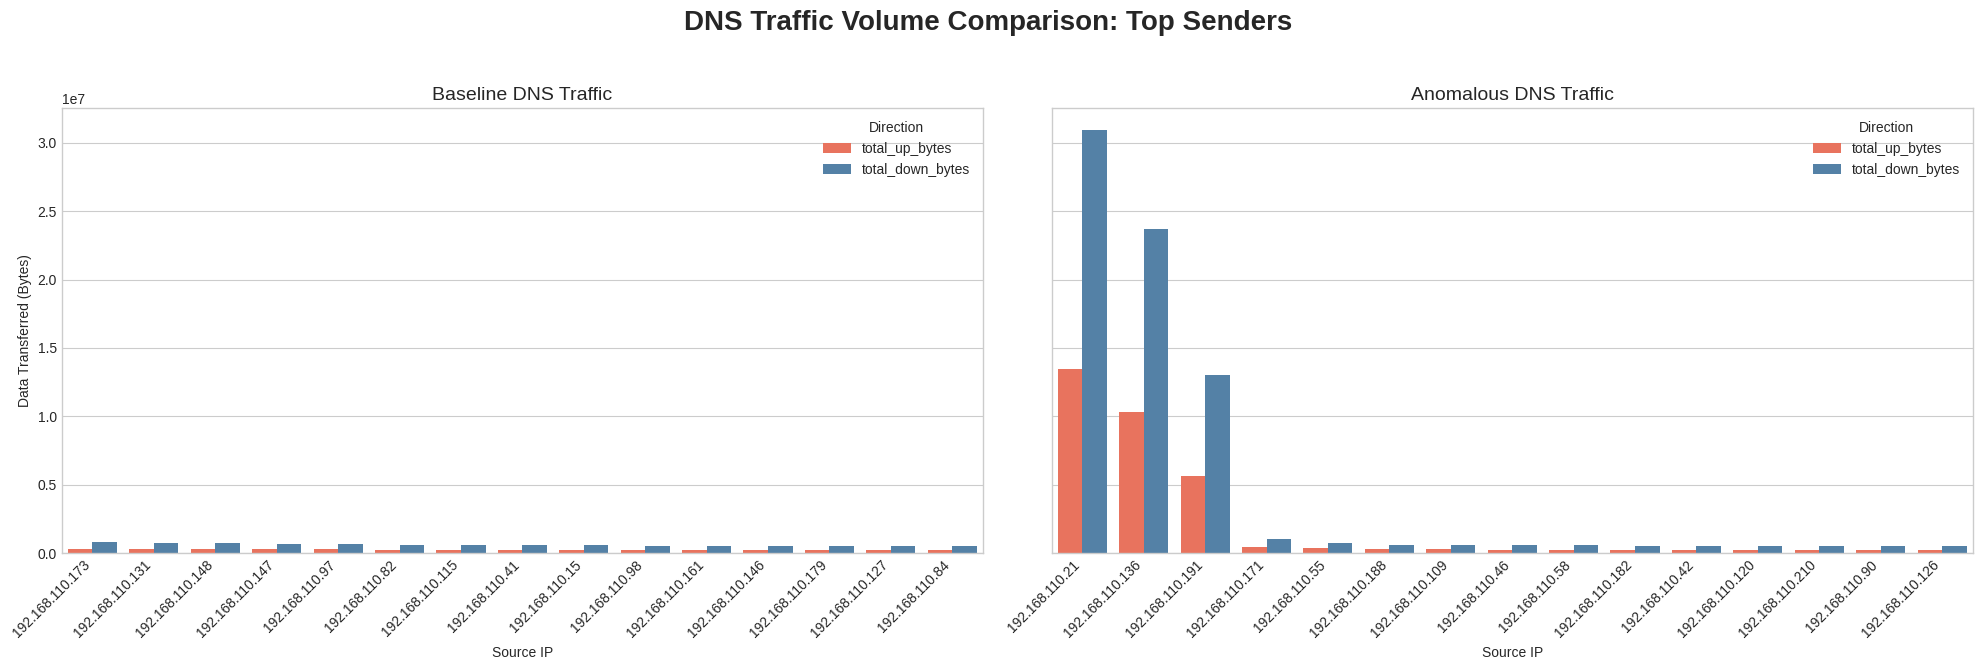

In [10]:
def plot_dns_volume_comparison(siem, top_n=15):
    """
    Plots DNS upload/download volume for top clients in baseline and anomalous data.
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
    fig.suptitle('DNS Traffic Volume Comparison: Top Senders', fontsize=20, fontweight='bold')

    if not siem.baseline_dns_volume.empty:
        baseline_data = siem.baseline_dns_volume.copy()
        baseline_data['total_volume'] = baseline_data['total_up_bytes'] + baseline_data['total_down_bytes']
        plot_data_base = baseline_data.nlargest(top_n, 'total_volume')
        plot_data_base_melted = plot_data_base.melt(
            id_vars='src_ip', value_vars=['total_up_bytes', 'total_down_bytes'],
            var_name='direction', value_name='bytes'
        )
        sns.barplot(data=plot_data_base_melted, x='src_ip', y='bytes', hue='direction', ax=axes[0],
                    palette={'total_up_bytes': '#ff6347', 'total_down_bytes': '#4682b4'})
        axes[0].set_title('Baseline DNS Traffic', fontsize=14)
        axes[0].set_xlabel('Source IP')
        axes[0].set_ylabel('Data Transferred (Bytes)')
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
        axes[0].legend(title='Direction')
    else:
        axes[0].text(0.5, 0.5, 'No DNS Traffic Found in Baseline', ha='center', va='center')
        axes[0].set_title('Baseline DNS Traffic', fontsize=14)

    if not siem.anomalous_dns_volume.empty:
        anomalous_data = siem.anomalous_dns_volume.copy()
        anomalous_data['total_volume'] = anomalous_data['total_up_bytes'] + anomalous_data['total_down_bytes']
        plot_data_anom = anomalous_data.nlargest(top_n, 'total_volume')
        plot_data_anom_melted = plot_data_anom.melt(
            id_vars='src_ip', value_vars=['total_up_bytes', 'total_down_bytes'],
            var_name='direction', value_name='bytes'
        )
        sns.barplot(data=plot_data_anom_melted, x='src_ip', y='bytes', hue='direction', ax=axes[1],
                    palette={'total_up_bytes': '#ff6347', 'total_down_bytes': '#4682b4'})
        axes[1].set_title('Anomalous DNS Traffic', fontsize=14)
        axes[1].set_xlabel('Source IP')
        axes[1].set_ylabel('')
        axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
        axes[1].legend(title='Direction')
    else:
        axes[1].text(0.5, 0.5, 'No DNS Traffic Found in Anomalous Data', ha='center', va='center')
        axes[1].set_title('Anomalous DNS Traffic', fontsize=14)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_dns_volume_comparison(siem)

In [11]:
def display_dns_variation_analysis(siem, threshold=0.8):
    """
    Displays hosts whose share of DNS traffic has significantly changed.
    """
    print("\n" + "-"*80)
    print("ANALYSIS: Variation in Share of Total DNS Traffic".center(80))
    print(f"(Highlighting hosts whose traffic share changed by more than {threshold} percentage points)")
    print( "-"*80)
    
    df_variation = siem.dns_volume_variation
    
    if df_variation.empty:
        print("\nCould not compute DNS variation. One or both datasets may be missing DNS traffic.")
        return

    up_increase = df_variation[df_variation['up_bytes_variation'] > threshold]
    up_decrease = df_variation[df_variation['up_bytes_variation'] < -threshold]
    down_increase = df_variation[df_variation['down_bytes_variation'] > threshold]
    down_decrease = df_variation[df_variation['down_bytes_variation'] < -threshold]

    print("\n[ALERT] Hosts with Significant INCREASE in Upload Traffic Share:")
    if not up_increase.empty:
        display(up_increase.sort_values('up_bytes_variation', ascending=False))
    else:
        print("None detected.")

    print("\n[INFO] Hosts with Significant DECREASE in Upload Traffic Share:")
    if not up_decrease.empty:
        display(up_decrease.sort_values('up_bytes_variation'))
    else:
        print("None detected.")
        
    print("\n[ALERT] Hosts with Significant INCREASE in Download Traffic Share:")
    if not down_increase.empty:
        display(down_increase.sort_values('down_bytes_variation', ascending=False))
    else:
        print("None detected.")

    print("\n[INFO] Hosts with Significant DECREASE in Download Traffic Share:")
    if not down_decrease.empty:
        display(down_decrease.sort_values('down_bytes_variation'))
    else:
        print("None detected.")

display_dns_variation_analysis(siem, threshold=0.8)



--------------------------------------------------------------------------------
               ANALYSIS: Variation in Share of Total DNS Traffic                
(Highlighting hosts whose traffic share changed by more than 0.8 percentage points)
--------------------------------------------------------------------------------

[ALERT] Hosts with Significant INCREASE in Upload Traffic Share:


up_bytes_variation  down_bytes_variation
src_ip                                                   
192.168.110.21             7.675552             17.648686
192.168.110.136            5.910566             13.587806
192.168.110.191            3.141229              7.216614


[INFO] Hosts with Significant DECREASE in Upload Traffic Share:
None detected.

[ALERT] Hosts with Significant INCREASE in Download Traffic Share:


up_bytes_variation  down_bytes_variation
src_ip                                                   
192.168.110.21             7.675552             17.648686
192.168.110.136            5.910566             13.587806
192.168.110.191            3.141229              7.216614


[INFO] Hosts with Significant DECREASE in Download Traffic Share:


up_bytes_variation  down_bytes_variation
src_ip                                                   
192.168.110.173           -0.365488             -0.854186

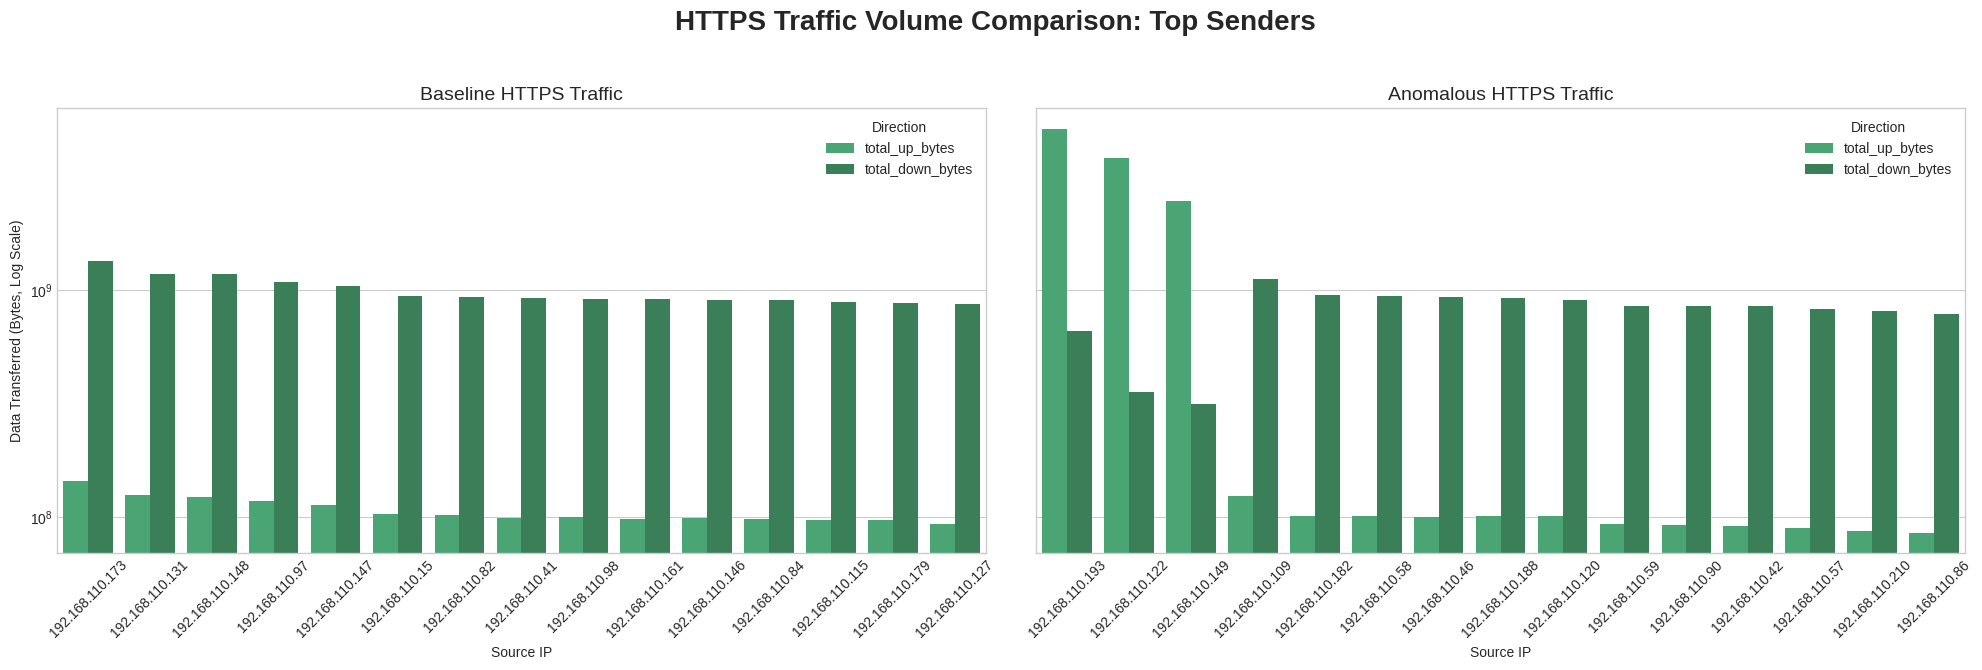

In [12]:
def plot_https_volume_comparison(siem, top_n=15):
    """
    Plots HTTPS upload/download volume for top clients in baseline and anomalous data.
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
    fig.suptitle('HTTPS Traffic Volume Comparison: Top Senders', fontsize=20, fontweight='bold')

    if not siem.baseline_https_volume.empty:
        baseline_data = siem.baseline_https_volume.copy()
        baseline_data['total_volume'] = baseline_data['total_up_bytes'] + baseline_data['total_down_bytes']
        plot_data_base = baseline_data.nlargest(top_n, 'total_volume')
        plot_data_base_melted = plot_data_base.melt(
            id_vars='src_ip', value_vars=['total_up_bytes', 'total_down_bytes'],
            var_name='direction', value_name='bytes'
        )
        sns.barplot(data=plot_data_base_melted, x='src_ip', y='bytes', hue='direction', ax=axes[0],
                    palette={'total_up_bytes': '#3cb371', 'total_down_bytes': '#2e8b57'})
        axes[0].set_title('Baseline HTTPS Traffic', fontsize=14)
        axes[0].set_xlabel('Source IP')
        axes[0].set_ylabel('Data Transferred (Bytes)')
        axes[0].tick_params(axis='x', rotation=45, labelright=False, right=False)
        axes[0].legend(title='Direction')
        if plot_data_base['total_volume'].max() > 1e9:
            axes[0].set_yscale('log')
            axes[0].set_ylabel('Data Transferred (Bytes, Log Scale)')

    else:
        axes[0].text(0.5, 0.5, 'No HTTPS Traffic Found in Baseline', ha='center', va='center')
        axes[0].set_title('Baseline HTTPS Traffic', fontsize=14)

    if not siem.anomalous_https_volume.empty:
        anomalous_data = siem.anomalous_https_volume.copy()
        anomalous_data['total_volume'] = anomalous_data['total_up_bytes'] + anomalous_data['total_down_bytes']
        plot_data_anom = anomalous_data.nlargest(top_n, 'total_volume')
        plot_data_anom_melted = plot_data_anom.melt(
            id_vars='src_ip', value_vars=['total_up_bytes', 'total_down_bytes'],
            var_name='direction', value_name='bytes'
        )
        sns.barplot(data=plot_data_anom_melted, x='src_ip', y='bytes', hue='direction', ax=axes[1],
                    palette={'total_up_bytes': '#3cb371', 'total_down_bytes': '#2e8b57'})
        axes[1].set_title('Anomalous HTTPS Traffic', fontsize=14)
        axes[1].set_xlabel('Source IP')
        axes[1].set_ylabel('')
        axes[1].tick_params(axis='x', rotation=45, labelright=False, right=False)
        axes[1].legend(title='Direction')
        if plot_data_anom['total_volume'].max() > 1e9:
            axes[1].set_yscale('log')

    else:
        axes[1].text(0.5, 0.5, 'No HTTPS Traffic Found in Anomalous Data', ha='center', va='center')
        axes[1].set_title('Anomalous HTTPS Traffic', fontsize=14)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_https_volume_comparison(siem)

In [39]:
def display_https_variation_analysis(siem, threshold=1.0):
    """
    Displays hosts whose share of total HTTPS traffic has significantly changed,
    breaking it down by upload and download variation.
    
    Args:
        siem (UltimateSIEM): The instantiated SIEM object after analysis.
        threshold (float): The percentage point change to consider significant.
    """
    print("\n" + "-"*80)
    print("ANALYSIS: Variation in Share of Total HTTPS Traffic".center(80))
    print(f"(Highlighting hosts whose traffic share changed by more than {threshold:.1f} percentage points)")
    print("-" * 80)
    
    df_variation = siem.https_volume_variation
    
    # --- FIX: Check for the correct columns and handle empty dataframe ---
    if df_variation.empty or 'up_bytes_variation' not in df_variation.columns:
        print("\nCould not compute HTTPS variation. Data may be missing.")
        return

    # Filter for significant variations in both directions
    up_increase = df_variation[df_variation['up_bytes_variation'] > threshold]
    up_decrease = df_variation[df_variation['up_bytes_variation'] < -threshold]
    down_increase = df_variation[df_variation['down_bytes_variation'] > threshold]
    down_decrease = df_variation[df_variation['down_bytes_variation'] < -threshold]

    print("\n[ALERT] Hosts with Significant INCREASE in Upload Traffic Share:")
    if not up_increase.empty:
        # Display the relevant column, sorted
        display(up_increase[['up_bytes_variation']].sort_values('up_bytes_variation', ascending=False))
    else:
        print("None detected.")

    print("\n[INFO] Hosts with Significant DECREASE in Upload Traffic Share:")
    if not up_decrease.empty:
        display(up_decrease[['up_bytes_variation']].sort_values('up_bytes_variation'))
    else:
        print("None detected.")
        
    print("\n[ALERT] Hosts with Significant INCREASE in Download Traffic Share:")
    if not down_increase.empty:
        display(down_increase[['down_bytes_variation']].sort_values('down_bytes_variation', ascending=False))
    else:
        print("None detected.")

    print("\n[INFO] Hosts with Significant DECREASE in Download Traffic Share:")
    if not down_decrease.empty:
        display(down_decrease[['down_bytes_variation']].sort_values('down_bytes_variation'))
    else:
        print("None detected.")

# Call the display function as before
display_https_variation_analysis(siem, threshold=1.0)


--------------------------------------------------------------------------------
              ANALYSIS: Variation in Share of Total HTTPS Traffic               
(Highlighting hosts whose traffic share changed by more than 1.0 percentage points)
--------------------------------------------------------------------------------

[ALERT] Hosts with Significant INCREASE in Upload Traffic Share:


up_bytes_variation
src_ip                             
192.168.110.193            4.696627
192.168.110.122            3.476915
192.168.110.149            2.284817


[INFO] Hosts with Significant DECREASE in Upload Traffic Share:
None detected.

[ALERT] Hosts with Significant INCREASE in Download Traffic Share:
None detected.

[INFO] Hosts with Significant DECREASE in Download Traffic Share:
None detected.


## internal threats

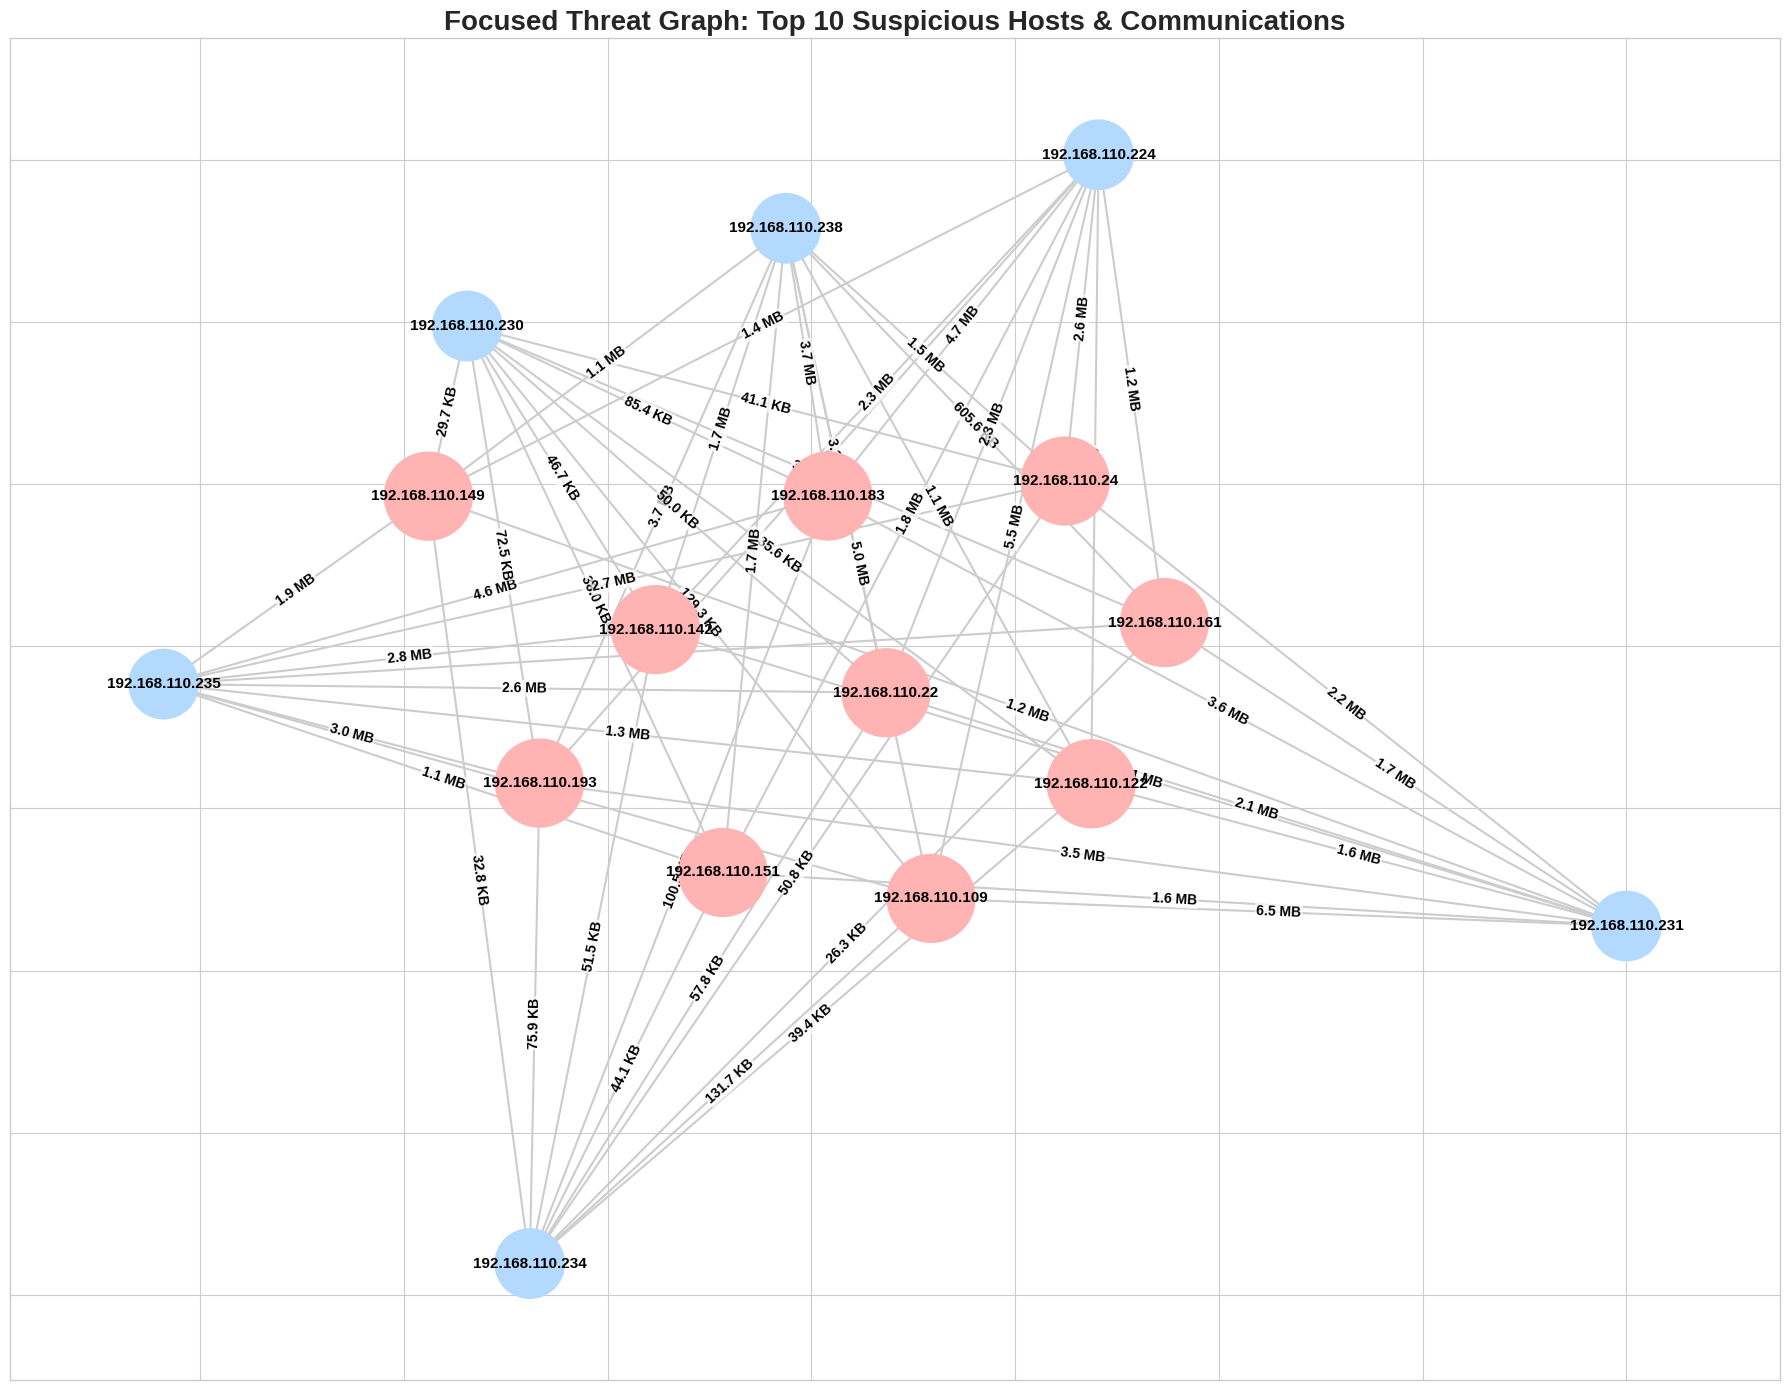

In [14]:
def plot_focused_internal_traffic(siem):
    """
    Plots a network graph of the most suspicious internal hosts and their communications.
    """
    if not siem.suspicion_report: return
    internal_report = {ip: d for ip, d in siem.suspicion_report.items() if siem._is_internal(ip)}
    if not internal_report: return
    final_scores = {ip: details['score'] for ip, details in internal_report.items()}
    sorted_suspects = sorted(final_scores.items(), key=lambda item: item[1], reverse=True)
    top_suspect_ips = [ip for ip, score in sorted_suspects[:TOP_N_SUSPECTS_TO_PLOT] if score >= MIN_SCORE_TO_PLOT]
    if not top_suspect_ips: return
    focused_traffic = siem.all_anomalous_internal_comms[
        (siem.all_anomalous_internal_comms['src_ip'].isin(top_suspect_ips)) |
        (siem.all_anomalous_internal_comms['dst_ip'].isin(top_suspect_ips))
    ].copy()
    if focused_traffic.empty: return
    graph_df = focused_traffic.groupby(['src_ip', 'dst_ip']).agg(total_up_bytes=('up_bytes_anom', 'sum')).reset_index()
    G = nx.from_pandas_edgelist(graph_df, 'src_ip', 'dst_ip', edge_attr='total_up_bytes', create_using=nx.DiGraph())
    if not G.nodes: return
    plt.figure(figsize=(18, 14))
    pos = nx.spring_layout(G, k=1.8, iterations=50)
    node_colors = ['#ffb3b3' if node in top_suspect_ips else '#b3d9ff' for node in G.nodes()]
    node_sizes = [4000 if node in top_suspect_ips else 2500 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, width=1.5, edge_color='#cccccc', arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', font_color='black')
    edge_weights = nx.get_edge_attributes(G, 'total_up_bytes')
    edge_labels = {edge: siem._format_bytes(weight) for edge, weight in edge_weights.items() if weight > 0}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=10, font_weight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    plt.title(f'Focused Threat Graph: Top {len(top_suspect_ips)} Suspicious Hosts & Communications', fontsize=20, fontweight='bold')
    plt.tight_layout()

plot_focused_internal_traffic(siem)


### Threat Vector: High-Volume Data Exfiltration
The most critical finding is the detection of massive data exfiltration over HTTPS. The graph below shows the path of this stolen data, with red lines indicating flows of over 1 GB.

**Finding**: The hosts **`192.168.110.193`**, **`192.168.110.122`**, and **`192.168.110.149`** are the primary exfiltrators, having stolen a combined **10.7 GB** of data. This is a definitive sign of a severe data breach.

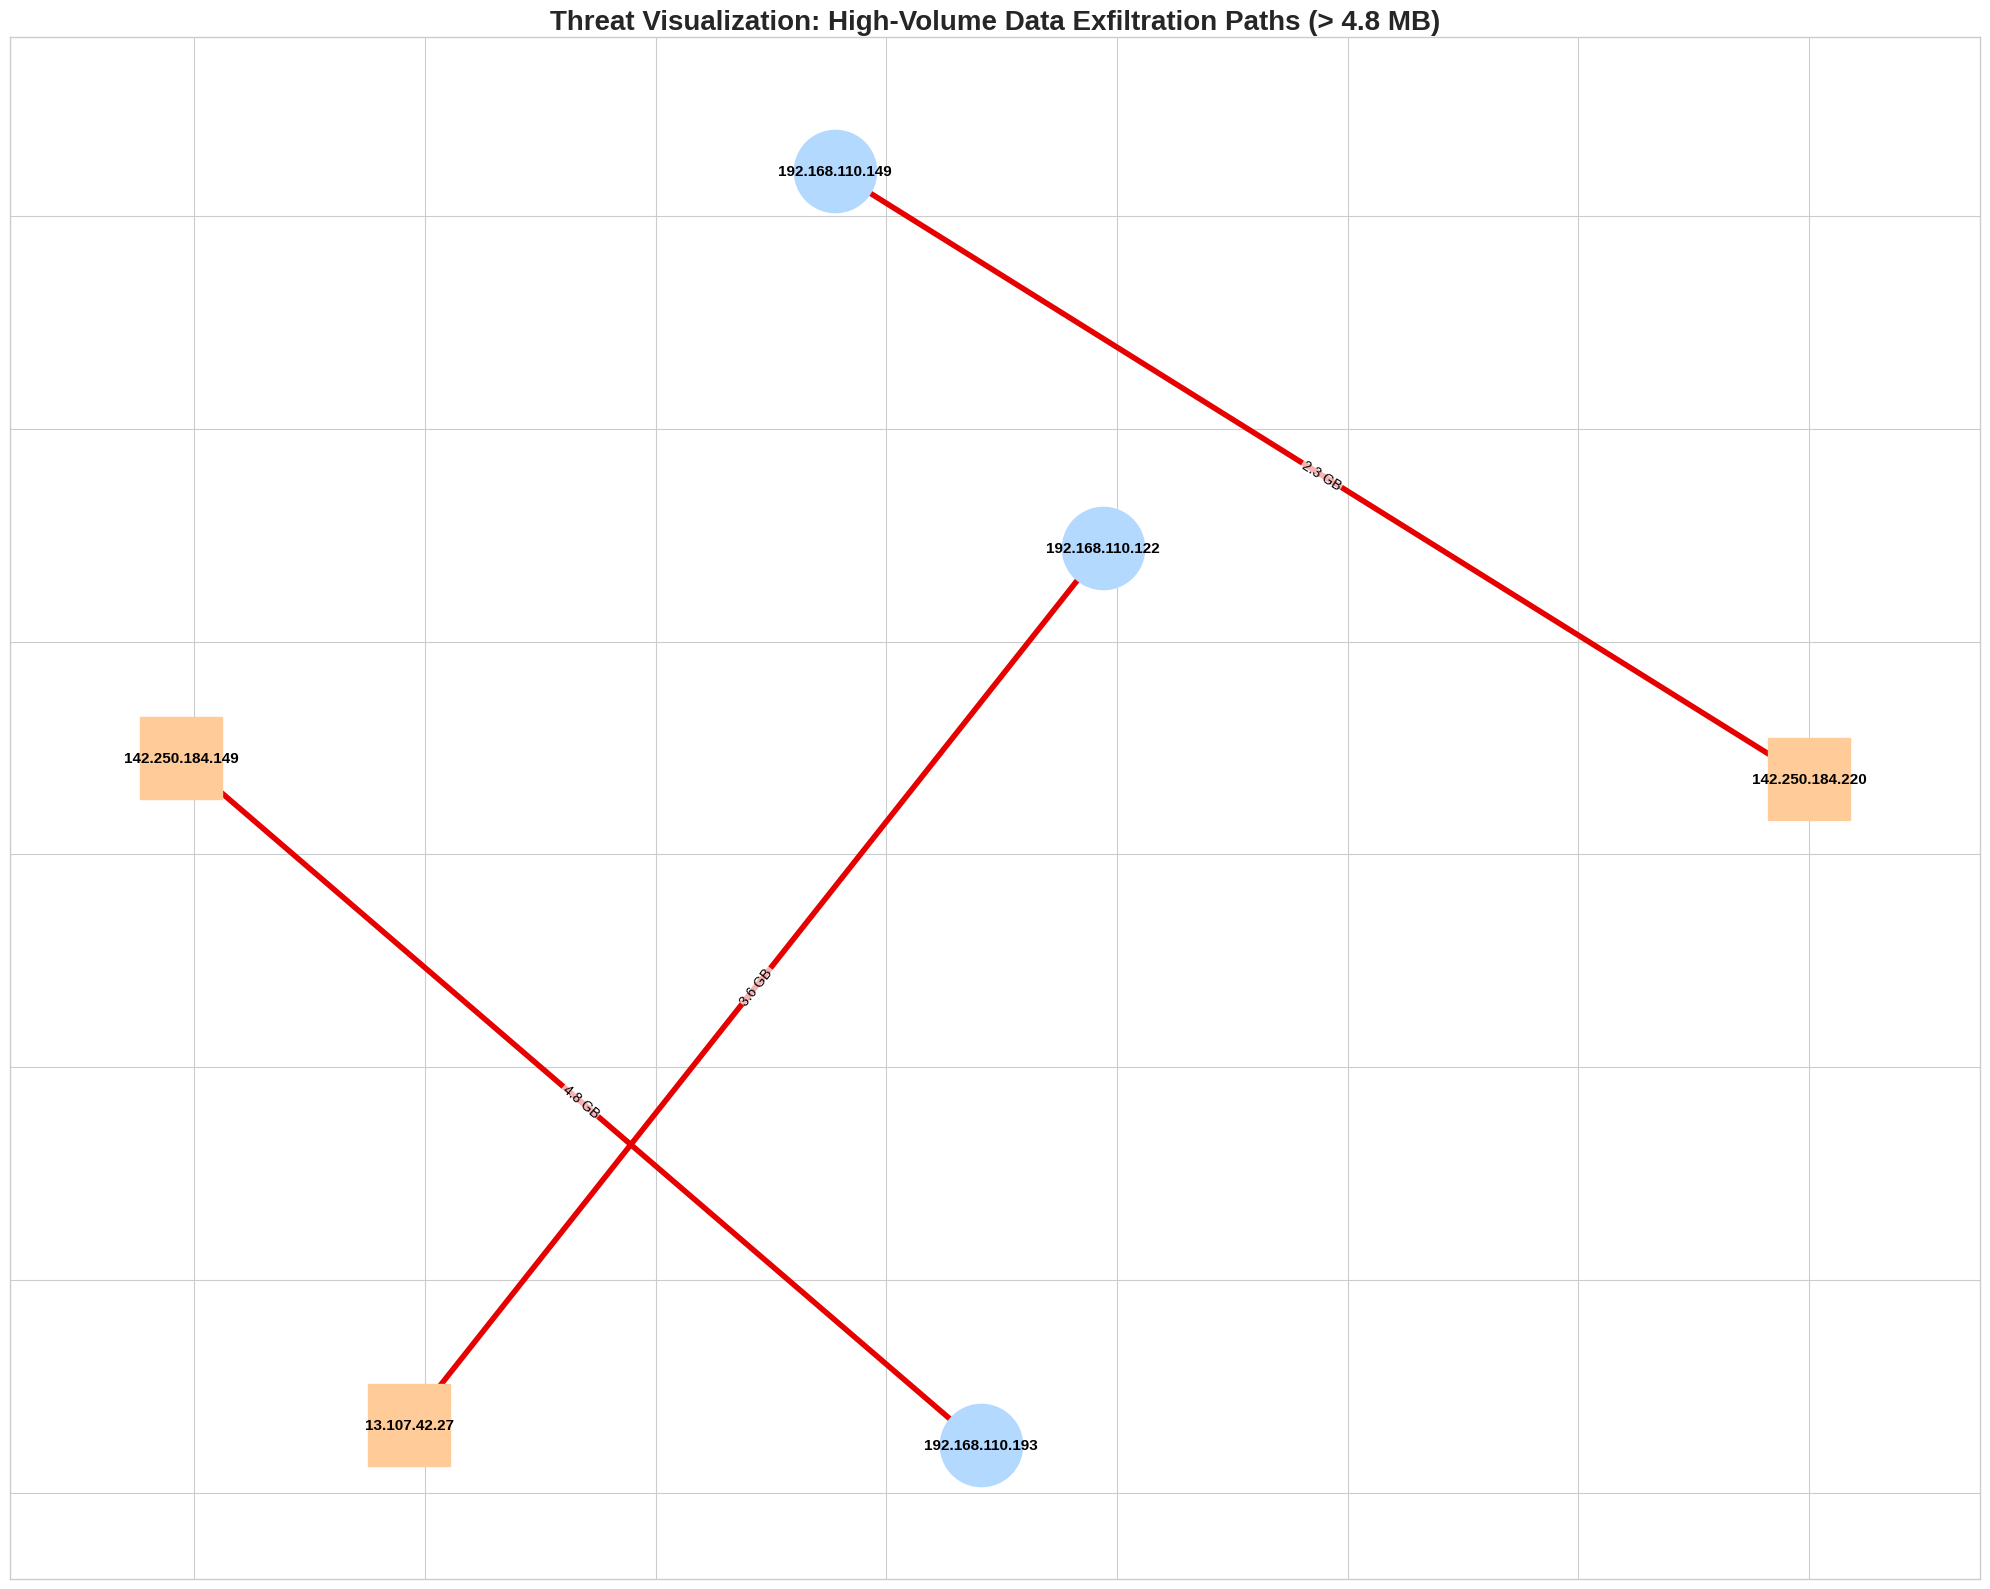

In [15]:
def plot_exfiltration_graph(siem):
    """
    Plots a network graph visualizing high-volume data exfiltration paths.
    """
    exfil_traffic = siem.anomalous_df[siem.anomalous_df['up_bytes'] >= MIN_BYTES_TO_PLOT_INTERNAL].copy()
    if exfil_traffic.empty: return
    graph_df = exfil_traffic.groupby(['src_ip', 'dst_ip']).agg(total_up_bytes=('up_bytes', 'sum')).reset_index()
    G = nx.from_pandas_edgelist(graph_df, 'src_ip', 'dst_ip', edge_attr='total_up_bytes', create_using=nx.DiGraph())
    if not G.nodes: return
    plt.figure(figsize=(20, 16))
    pos = nx.spring_layout(G, k=2.0, iterations=50)
    internal_nodes = [n for n in G.nodes() if siem._is_internal(n)]
    external_nodes = [n for n in G.nodes() if not siem._is_internal(n)]
    edges = G.edges(data=True)
    normal_edges = [(u, v) for u, v, d in edges if d['total_up_bytes'] < 1_000_000_000]
    critical_edges = [(u, v) for u, v, d in edges if d['total_up_bytes'] >= 1_000_000_000]
    nx.draw_networkx_nodes(G, pos, nodelist=internal_nodes, node_shape='o', node_size=3500, node_color='#b3d9ff')
    nx.draw_networkx_nodes(G, pos, nodelist=external_nodes, node_shape='s', node_size=3500, node_color='#ffcc99')
    nx.draw_networkx_edges(G, pos, edgelist=normal_edges, width=1.5, edge_color='#cccccc', arrowsize=20)
    nx.draw_networkx_edges(G, pos, edgelist=critical_edges, width=4.0, edge_color='#e60000', arrowsize=30)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', font_color='black')
    edge_weights = nx.get_edge_attributes(G, 'total_up_bytes')
    edge_labels = {edge: siem._format_bytes(weight) for edge, weight in edge_weights.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    plt.title(f'Threat Visualization: High-Volume Data Exfiltration Paths (> {siem._format_bytes(MIN_BYTES_TO_PLOT_INTERNAL)})', fontsize=20, fontweight='bold')
    plt.tight_layout()

plot_exfiltration_graph(siem)

#### Confirmed Data Exfiltration Volumes
The bar chart below quantifies the exact volume of data stolen by each of the top exfiltration hosts, confirming the severity of the breach.

/tmp/ipykernel_35143/2560492588.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='src_ip', y='up_gb', palette='Reds_r')


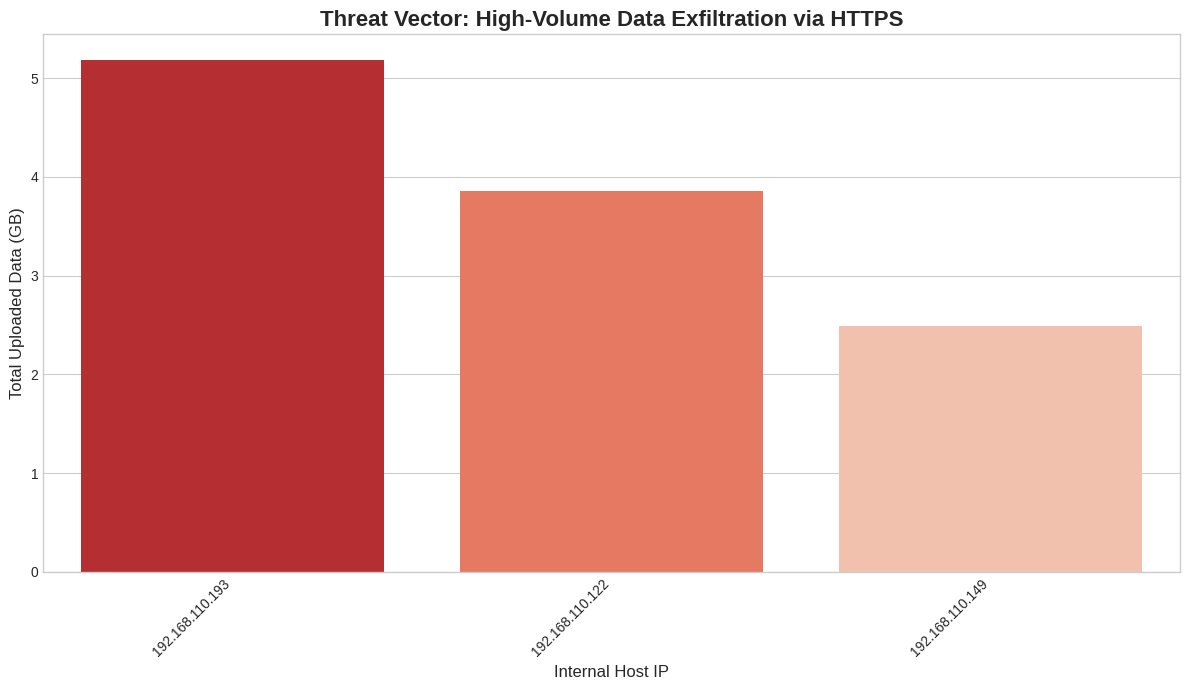

In [16]:
def plot_https_exfiltration(siem):
    """
    Plots a bar chart of top internal hosts by HTTPS data exfiltration volume.
    """
    if siem.https_exfil_candidates.empty: return
    df = siem.https_exfil_candidates.sort_values('up_bytes', ascending=False).head(10)
    df['up_gb'] = df['up_bytes'] / 1e9
    plt.figure(figsize=(12, 7))
    sns.barplot(data=df, x='src_ip', y='up_gb', palette='Reds_r')
    plt.ylabel('Total Uploaded Data (GB)', fontsize=12)
    plt.xlabel('Internal Host IP', fontsize=12)
    plt.title('Threat Vector: High-Volume Data Exfiltration via HTTPS', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plot_https_exfiltration(siem)

### Threat Vector: Command & Control (C&C) Beaconing
Infected machines, or "bots," need to communicate with an attacker's server to receive commands. This is often done through "beaconing"—sending out periodic, rhythmic signals. The chart below identifies internal hosts sending HTTPS requests with an extremely low standard deviation in their timing, the classic signature of automated C&C beaconing.

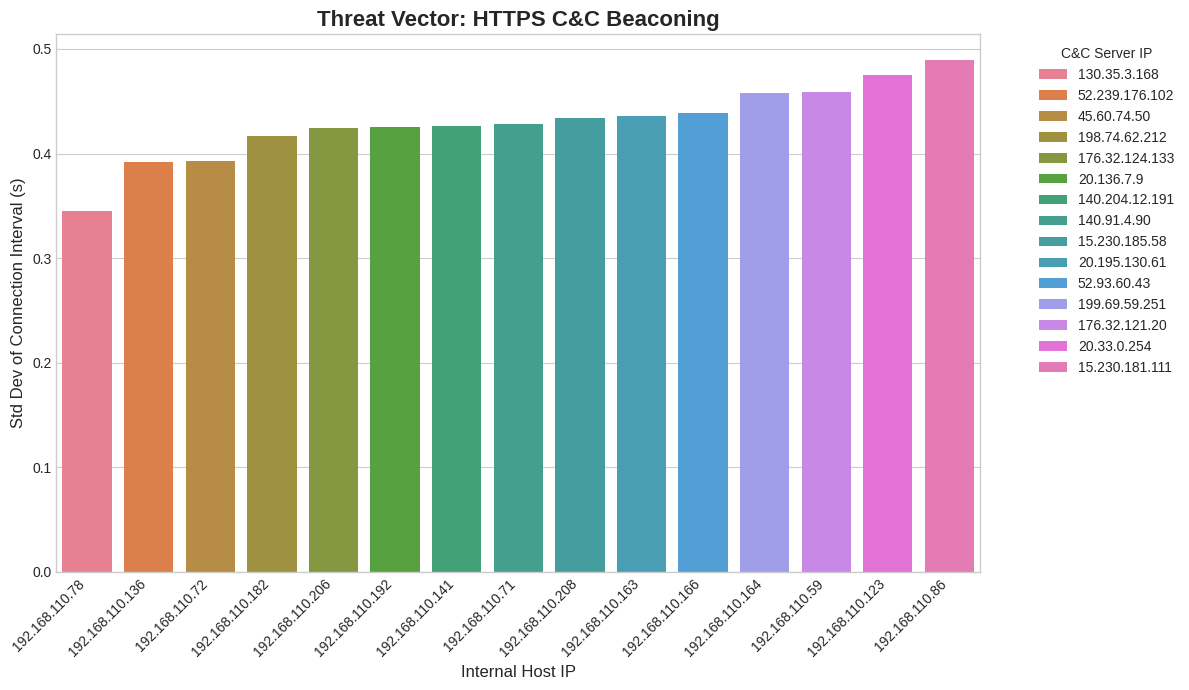

In [17]:
def plot_https_beaconing(siem):
    """
    Plots a bar chart of hosts suspected of HTTPS C&C beaconing.
    """
    if siem.https_beaconing_candidates.empty: return
    df = siem.https_beaconing_candidates.sort_values('interval_std').head(15)
    plt.figure(figsize=(12, 7))
    sns.barplot(data=df, x='src_ip', y='interval_std', hue='dst_ip', dodge=False)
    plt.ylabel('Std Dev of Connection Interval (s)', fontsize=12)
    plt.xlabel('Internal Host IP', fontsize=12)
    plt.title('Threat Vector: HTTPS C&C Beaconing', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='C&C Server IP', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

plot_https_beaconing(siem)

In [18]:

def plot_dns_tunneling(siem):
    """
    Generates a bar plot for hosts suspected of DNS tunneling.
    """
    if siem.dns_tunneling_candidates.empty:
        print("\nNote: No DNS tunneling (exfiltration) candidates were detected to plot.")
        return
        
    df = siem.dns_tunneling_candidates.sort_values('ratio', ascending=False).head(15)
    
    plt.figure(figsize=(12, 7))
    sns.barplot(data=df, x='src_ip', y='ratio', palette='Greens_r')
    
    plt.ylabel('Upload/Download Ratio', fontsize=12)
    plt.xlabel('Internal Host IP (Source of Tunneling)', fontsize=12)
    plt.title('Threat Vector: Data Exfiltration via DNS Tunneling', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plot_dns_tunneling(siem)


Note: No DNS tunneling (exfiltration) candidates were detected to plot.


### Threat Vector: Communication with High-Risk Geopolitical Regions
A crucial part of the investigation is to determine the location of the attacker's infrastructure. By comparing the baseline and anomalous traffic, we identified new, high-volume communication channels to countries on our critical-risk list.

**Finding**: The analysis confirms new, high-confidence C&C channels to servers located in **Russia (RU)** and **Iran (IR)**, countries with which there is no legitimate business traffic.

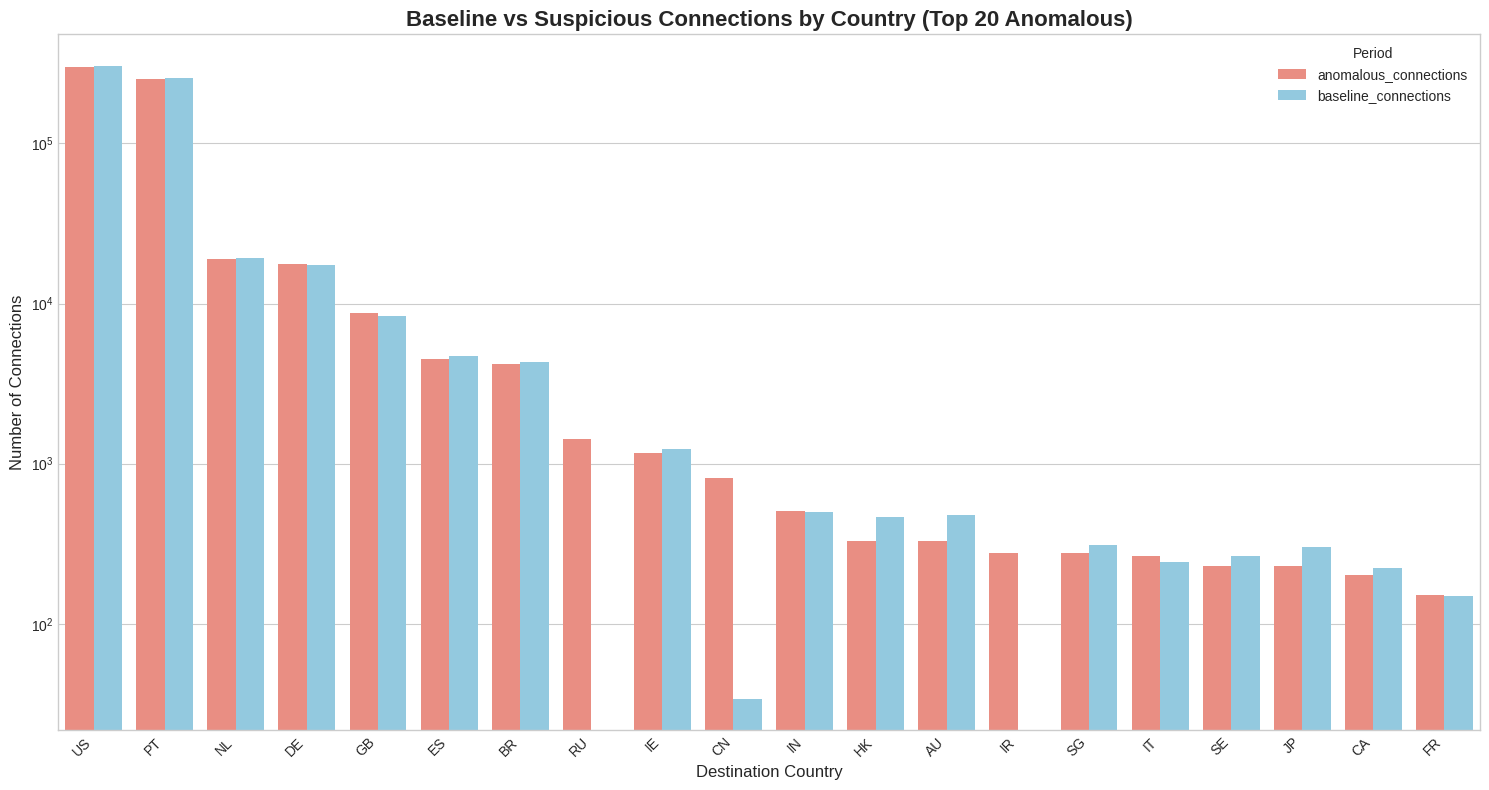

In [19]:
def plot_geo_comparison(siem):
    """
    Plots a comparison of connections per country for baseline vs anomalous data.
    """
    if siem.suspicious_geo_comms.empty:
        return

    anomalous_counts = siem.suspicious_geo_comms['country'].value_counts().reset_index()
    anomalous_counts.columns = ['country', 'anomalous_connections']

    baseline_counts = siem.baseline_geo_comms['country'].value_counts().reset_index()
    baseline_counts.columns = ['country', 'baseline_connections']

    df_merged = pd.merge(anomalous_counts, baseline_counts, on='country', how='outer').fillna(0)
    df_plot = df_merged.sort_values('anomalous_connections', ascending=False).head(20)
    df_melted = df_plot.melt(id_vars='country', var_name='period', value_name='connections')
    
    plt.figure(figsize=(15, 8))
    sns.barplot(data=df_melted, x='country', y='connections', hue='period', palette={'baseline_connections': 'skyblue', 'anomalous_connections': 'salmon'})
    
    plt.ylabel('Number of Connections', fontsize=12)
    plt.xlabel('Destination Country', fontsize=12)
    plt.title('Baseline vs Suspicious Connections by Country (Top 20 Anomalous)', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yscale('log')
    plt.legend(title='Period')
    plt.tight_layout()

plot_geo_comparison(siem)

In [20]:
def display_internal_correlation_results(siem):
    """
    Displays the results from the internal threat correlation engine.
    """
    print("\n" + "="*80)
    print("🚨 INTERNAL THREAT CORRELATION ENGINE: RESULTS 🚨".center(80))
    print("="*80)

    if siem.internal_correlation_scores.empty:
        print("\nNo correlated internal threats were found.")
        print("="*80)
        return

    print("\n--- Top Internal Suspects (by number of malicious behaviors detected) ---\n")
    display(siem.internal_correlation_scores.head(15))

    if siem.confirmed_cnc_channels:
        print("\n--- HIGH-CONFIDENCE: Confirmed C&C Channel ---")
        print("(Hosts are beaconing/exfiltrating AND communicating with a high-risk or new country)")
        for ip in siem.confirmed_cnc_channels[:10]: print(f"  - {ip}")

    if siem.active_internal_intruders:
        print("\n--- HIGH-CONFIDENCE: Active Internal Intruder ---")
        print("(Hosts have a C&C channel AND are performing internal network scanning)")
        for ip in siem.active_internal_intruders[:10]: print(f"  - {ip}")

    if siem.full_internal_compromise:
        print("\n--- CRITICAL ALERT: Full Internal Compromise Detected ---")
        print("(Hosts are scanning internally AND actively exfiltrating large volumes of data via HTTPS)")
        for ip in siem.full_internal_compromise[:10]: print(f"  - {ip}")
        
    print("\n" + "="*80)

display_internal_correlation_results(siem)


                🚨 INTERNAL THREAT CORRELATION ENGINE: RESULTS 🚨                 

--- Top Internal Suspects (by number of malicious behaviors detected) ---



src_ip  threat_score
8   192.168.110.149             2
32  192.168.110.163             2
38   192.168.110.89             2
0    192.168.110.72             1
1   192.168.110.122             1
4   192.168.110.101             1
5   192.168.110.165             1
3   192.168.110.123             1
2   192.168.110.193             1
7   192.168.110.166             1
6    192.168.110.91             1
9   192.168.110.206             1
10  192.168.110.182             1
13   192.168.110.71             1
14  192.168.110.141             1


--- HIGH-CONFIDENCE: Confirmed C&C Channel ---
(Hosts are beaconing/exfiltrating AND communicating with a high-risk or new country)
  - 192.168.110.163

--- HIGH-CONFIDENCE: Active Internal Intruder ---
(Hosts have a C&C channel AND are performing internal network scanning)
  - 192.168.110.149

--- CRITICAL ALERT: Full Internal Compromise Detected ---
(Hosts are scanning internally AND actively exfiltrating large volumes of data via HTTPS)
  - 192.168.110.149



#### Overall Suspicion Score
The chart below visualizes the final suspicion scores for the top internal threats, providing a clear hierarchy for incident response.

**Key Insight**: The scoring engine successfully prioritized hosts based on the severity and combination of their actions. For example, **`192.168.110.149`** received the highest score due to its "critical combo" of both lateral movement and active data exfiltration, marking it as the likely **Patient Zero**.

/tmp/ipykernel_35143/950817607.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ips, y=scores, palette="Reds_r")


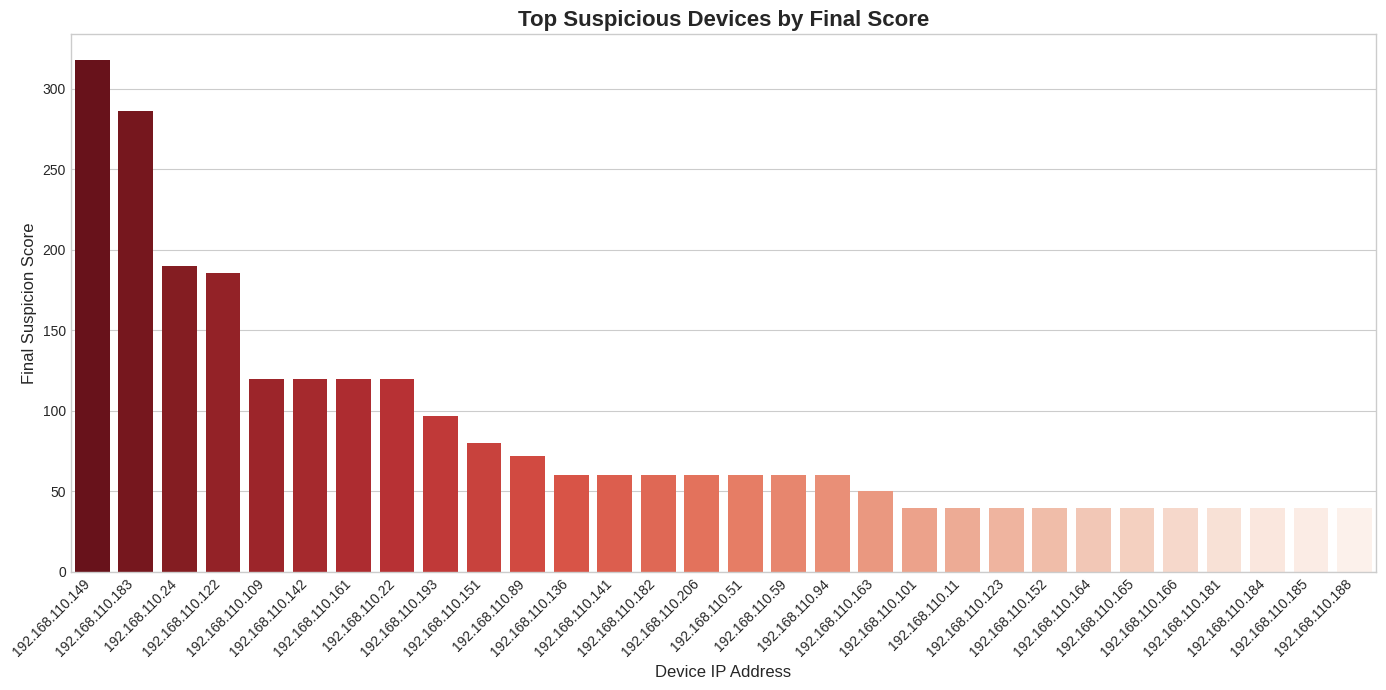

In [21]:
def plot_suspicion_scores(siem):
    """
    Plots a bar chart of the top suspicious internal devices by final calculated score.
    """
    internal_suspicion_report = {ip: details for ip, details in siem.suspicion_report.items() if siem._is_internal(ip)}
    if not internal_suspicion_report: return
    
    final_scores_dict = {}
    for ip, details in internal_suspicion_report.items():
        final_score = details['score']
        tags = details['tags']
        is_scanning = "LATERAL_SCAN" in tags
        is_stealing = "HTTPS_EXFIL" in tags or "DATA_STAGING" in tags
        is_beaconing = "HTTPS_BEACON" in tags or "DNS_TUNNEL" in tags
        if (is_scanning and is_stealing) or (is_beaconing and is_stealing):
            final_score *= CRITICAL_COMBO_MULTIPLIER
        final_scores_dict[ip] = final_score

    if not final_scores_dict: return
    
    sorted_scores = sorted(final_scores_dict.items(), key=lambda item: item[1], reverse=True)[:30]
    ips = [item[0] for item in sorted_scores]
    scores = [item[1] for item in sorted_scores]

    plt.figure(figsize=(14, 7))
    sns.barplot(x=ips, y=scores, palette="Reds_r")
    plt.ylabel('Final Suspicion Score', fontsize=12)
    plt.xlabel('Device IP Address', fontsize=12)
    plt.title('Top Suspicious Devices by Final Score', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plot_suspicion_scores(siem)

## Part 2: Analysis of the External Attack on Corporate Servers
Simultaneously, our public-facing servers were under a sustained attack. The analysis of `servers10.parquet` reveals a coordinated botnet campaign.

/tmp/ipykernel_35143/3812060582.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='network', y='unique_client_ips', palette='viridis_r')


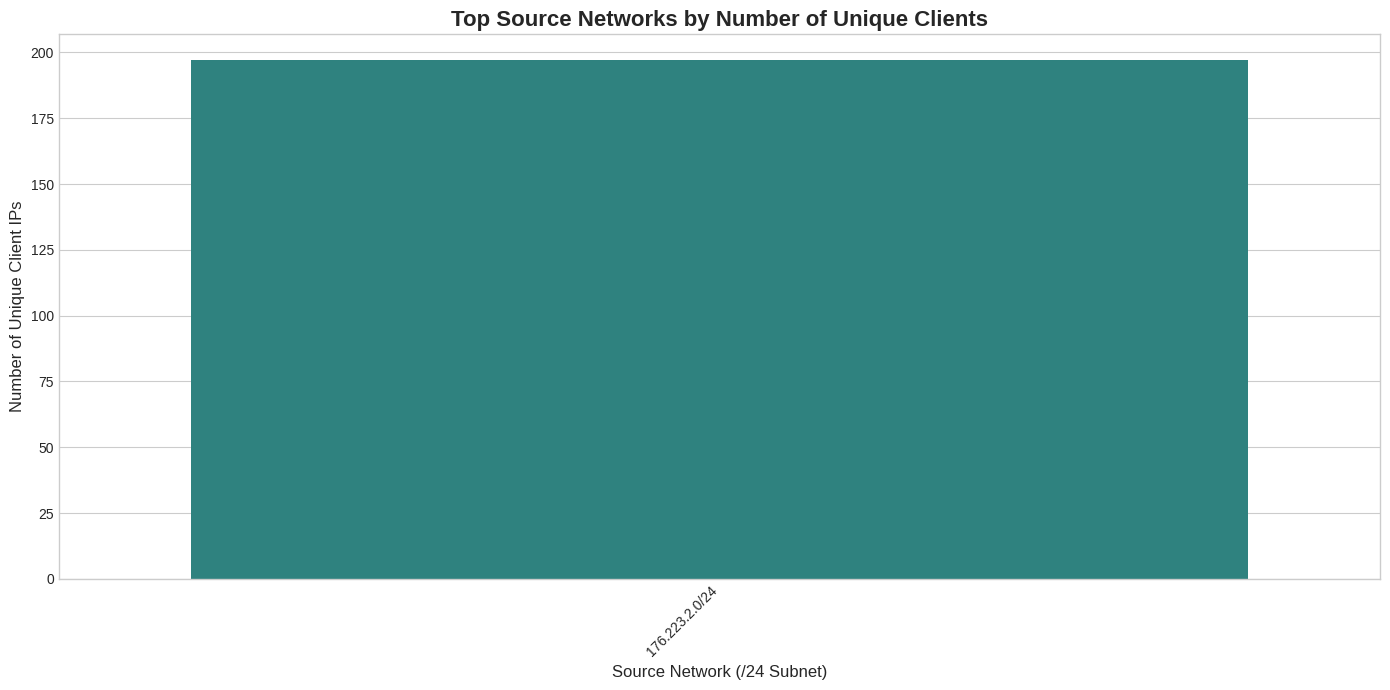

In [22]:
def plot_source_networks(siem):
    """
    Generates a bar plot showing the number of unique clients from top source networks.
    """
    if siem.source_networks.empty:
        print("\nNote: No source network data was generated to plot.")
        return
        
    df = siem.source_networks.head(20)
    
    plt.figure(figsize=(14, 7))
    sns.barplot(data=df, x='network', y='unique_client_ips', palette='viridis_r')
    
    plt.ylabel('Number of Unique Client IPs', fontsize=12)
    plt.xlabel('Source Network (/24 Subnet)', fontsize=12)
    plt.title('Top Source Networks by Number of Unique Clients', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plot_source_networks(siem)

#### Protocol Analysis of Inbound Traffic
First, we analyze the protocols used by external clients.

**Observation**: The traffic is almost exclusively HTTPS (port 443), indicating the attack is targeting our public-facing web services.

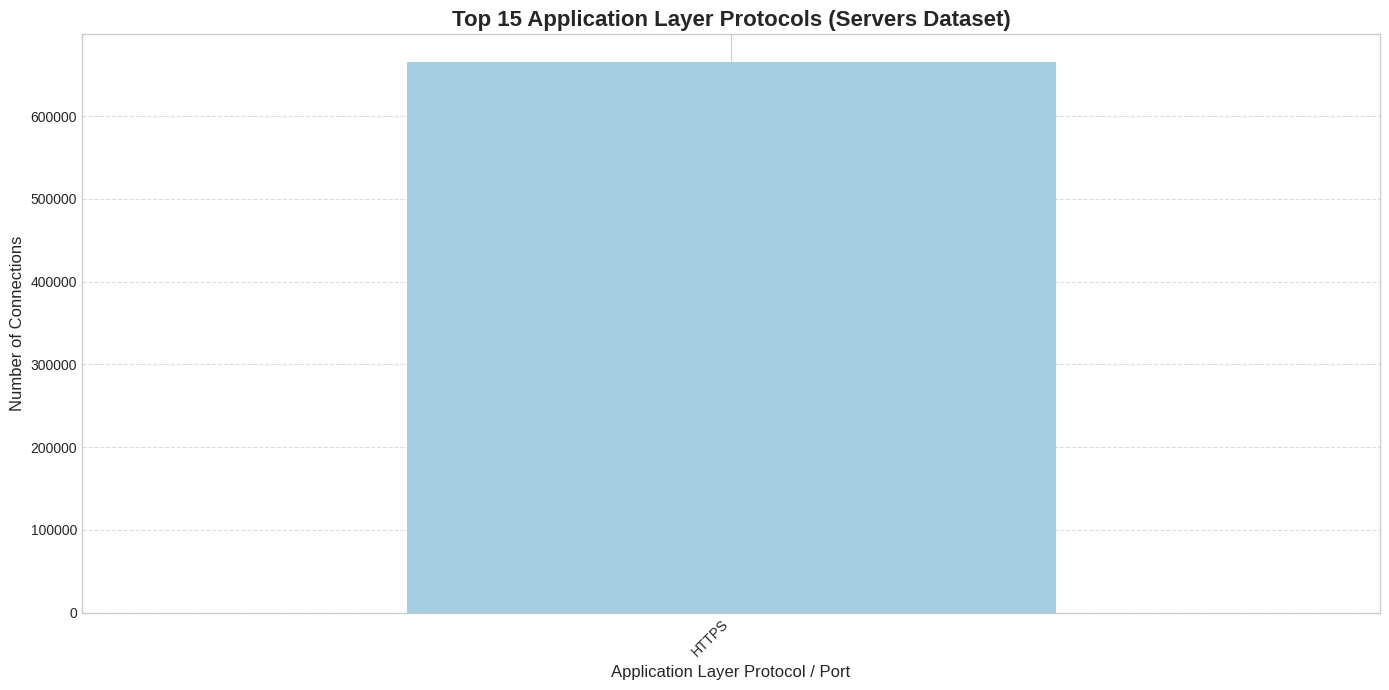


--- Protocol Ratios for Servers Dataset ---
Total Connections: 665639
Ratio of HTTPS packets: 100.00%
Ratio of DNS packets: 0.00%


In [23]:
def analyze_and_plot_servers_protocols(siem, top_n=15):
    """
    Analyzes and plots the port distribution for the servers.parquet dataset.
    """
    if siem.servers_df is None or siem.servers_df.empty:
        print("\nNote: No servers data is available to analyze.")
        return

    application_protocols = {
        '21': 'FTP', '22': 'SSH', '23': 'Telnet', '25': 'SMTP', '53': 'DNS',
        '80': 'HTTP', '110': 'POP3', '143': 'IMAP', '443': 'HTTPS', '445': 'SMB',
        '993': 'IMAPS', '995': 'POP3S', '1433': 'MS SQL', '3306': 'MySQL', '3389': 'RDP',
        '5900': 'VNC', '8080': 'HTTP Proxy'
    }
    
    servers_df = siem.servers_df
    protocol_series = servers_df['port'].astype(str).map(application_protocols)
    port_counts = protocol_series.fillna(servers_df['port'].astype(str)).value_counts()

    if len(port_counts) > top_n:
        top_ports = port_counts.nlargest(top_n)
        other_count = port_counts.iloc[top_n:].sum()
        if other_count > 0:
             top_ports['Other Ports'] = other_count
    else:
        top_ports = port_counts

    plt.figure(figsize=(14, 7))
    colors = sns.color_palette("Paired", n_colors=len(top_ports))
    top_ports.plot(kind='bar', color=colors)
    plt.title(f'Top {top_n} Application Layer Protocols (Servers Dataset)', fontsize=16, fontweight='bold')
    plt.xlabel('Application Layer Protocol / Port', fontsize=12)
    plt.ylabel('Number of Connections', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    total_packets = len(servers_df)
    https_packets = len(servers_df[servers_df["port"] == 443])
    dns_packets = len(servers_df[servers_df["port"] == 53])
    
    https_ratio = (https_packets / total_packets) * 100 if total_packets > 0 else 0
    dns_ratio = (dns_packets / total_packets) * 100 if total_packets > 0 else 0
    
    print(f"\n--- Protocol Ratios for Servers Dataset ---")
    print(f"Total Connections: {total_packets}")
    print(f"Ratio of HTTPS packets: {https_ratio:.2f}%")
    print(f"Ratio of DNS packets: {dns_ratio:.2f}%")

analyze_and_plot_servers_protocols(siem)

### Threat Vector: Connection Flood & Brute-Force Scanning
The primary tactic employed by the botnet was high-volume connection flooding, indicative of a large-scale scanning or credential stuffing campaign.

**Finding**: A large number of IPs from the **`176.223.2.0/24`** subnet are responsible for thousands of connections each, far exceeding normal traffic levels. This confirms a coordinated flood attack from a single botnet.

/tmp/ipykernel_35143/2212987093.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='src_ip', y='connection_count', palette='Oranges_r')


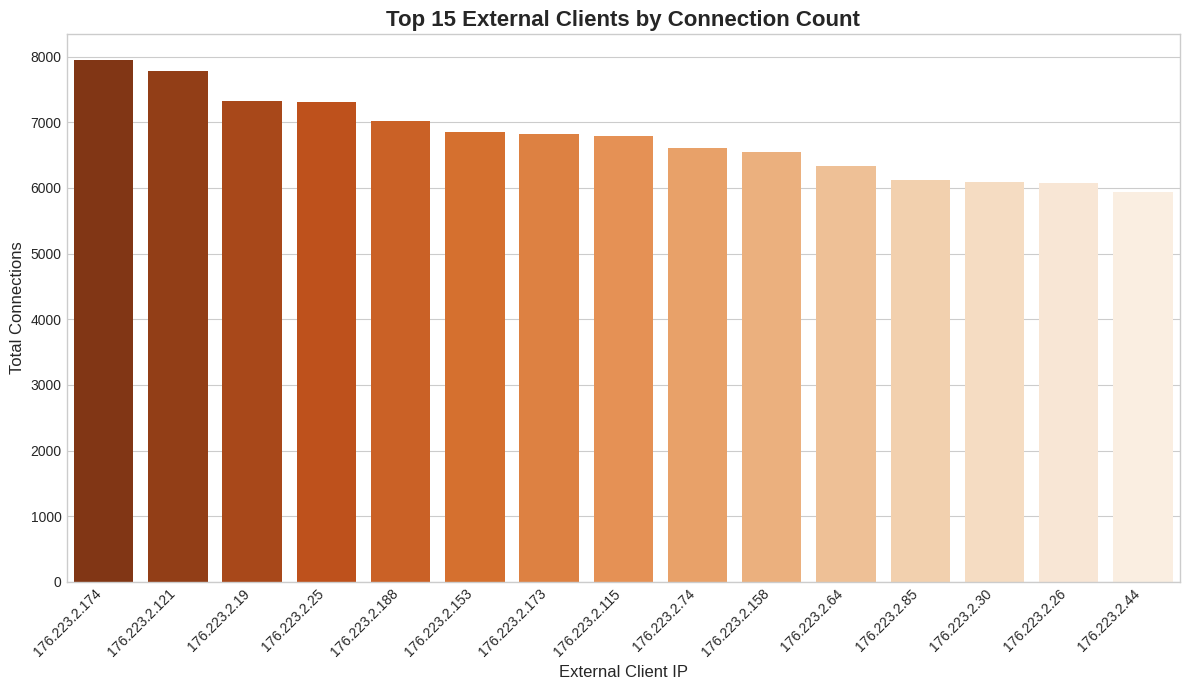

In [24]:
def plot_brute_force_candidates(siem):
    """
    Plots a bar chart of the top external clients by total connection count.
    """
    if siem.brute_force_candidates.empty: return
    df_plot = siem.brute_force_candidates.head(TOP_N_EXTERNAL_PLOT)
    plt.figure(figsize=(12, 7))
    sns.barplot(data=df_plot, x='src_ip', y='connection_count', palette='Oranges_r')
    plt.ylabel('Total Connections', fontsize=12)
    plt.xlabel('External Client IP', fontsize=12)
    plt.title(f'Top {TOP_N_EXTERNAL_PLOT} External Clients by Connection Count', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()


plot_brute_force_candidates(siem)

### Threat Vector: 24/7 Automated Operations
To confirm this activity was automated, we analyzed connection times. The bots showed a clear disregard for human working hours.

/tmp/ipykernel_35143/2377771593.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='src_ip', y='after_hours_connections', palette='magma_r')


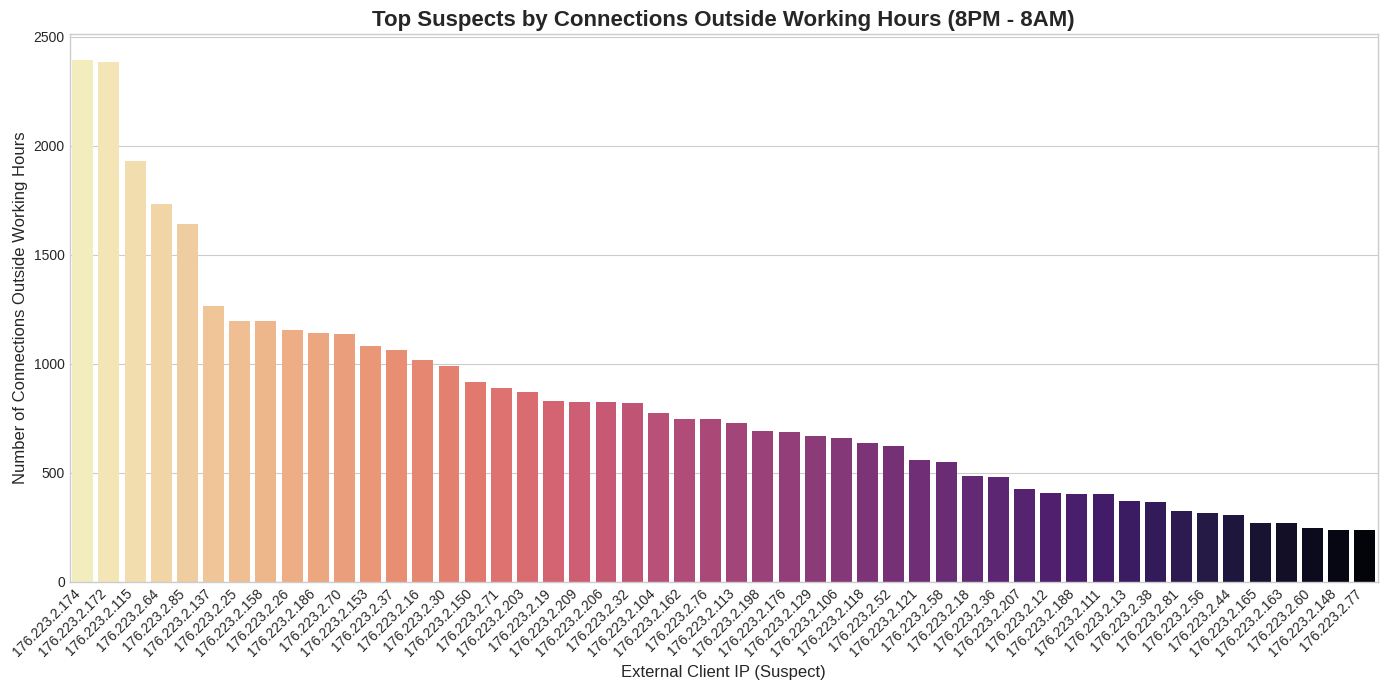

In [25]:
def plot_after_hours_suspects(siem):
    """
    Generates a bar plot of clients with the most connections outside working hours.
    """
    if siem.after_hours_suspects.empty:
        print("\nNote: No after-hours suspects were detected to plot.")
        return
        
    df = siem.after_hours_suspects
    
    plt.figure(figsize=(14, 7))
    sns.barplot(data=df, x='src_ip', y='after_hours_connections', palette='magma_r')
    
    plt.ylabel('Number of Connections Outside Working Hours', fontsize=12)
    plt.xlabel('External Client IP (Suspect)', fontsize=12)
    plt.title('Top Suspects by Connections Outside Working Hours (8PM - 8AM)', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plot_after_hours_suspects(siem)

#### Hourly Activity Heatmap
The heatmap below visualizes the connection patterns of the top suspects by the hour of the day.

**Observation**: The bright yellow and dark red bands stretching across all hours of the day confirm that the bots were operating continuously, without sleep or breaks. This is the classic signature of a 24/7 automated botnet.

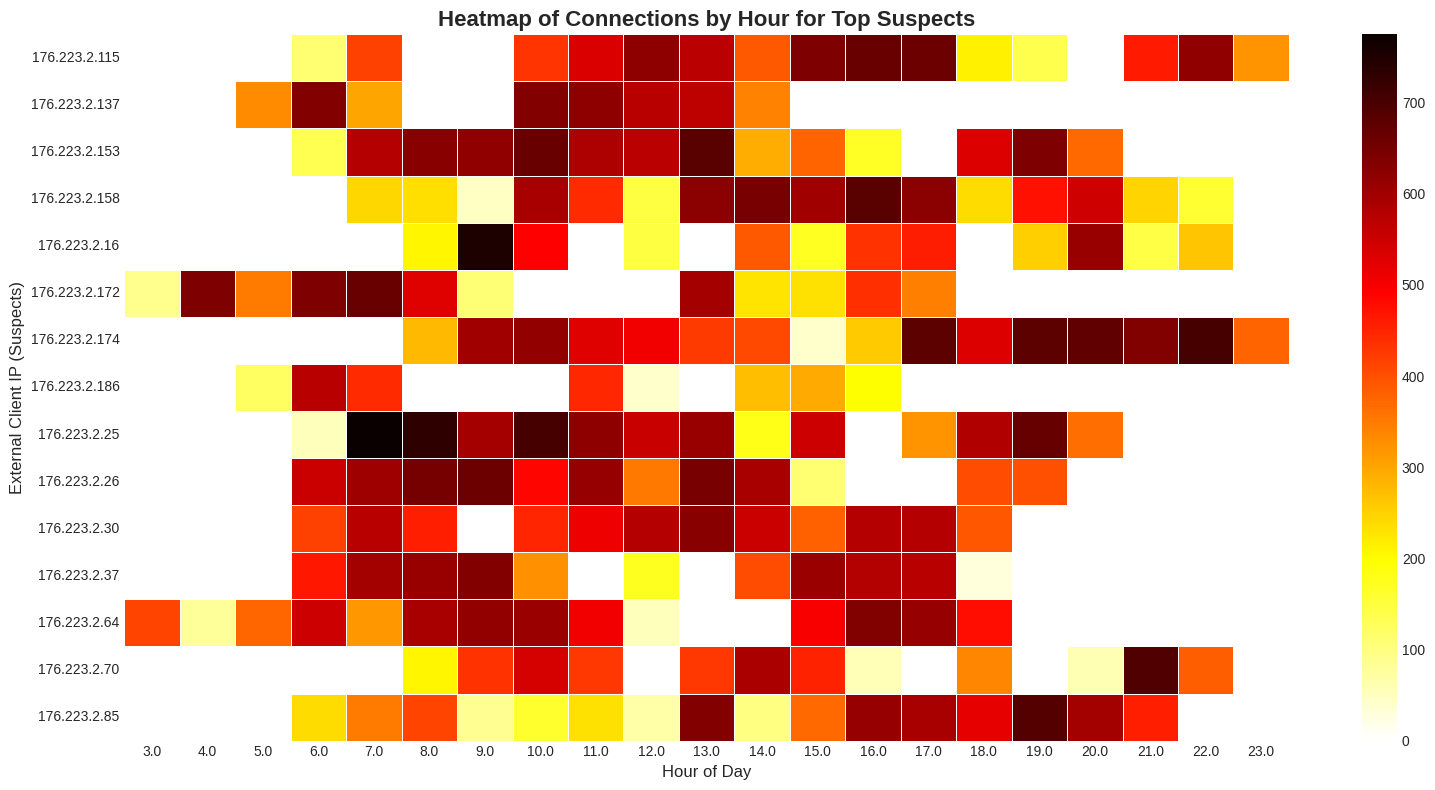

In [26]:
def plot_suspect_heatmap(siem):
    """
    Generates a heatmap of connection activity by hour for top suspects.
    """
    if siem.hourly_suspect_activity.empty:
        print("\nNote: No hourly suspect activity data was generated to plot.")
        return
        
    df_heatmap = siem.hourly_suspect_activity
    
    plt.figure(figsize=(16, 8))
    sns.heatmap(df_heatmap, cmap="hot_r", linewidths=.5, annot=False)
    
    plt.ylabel('External Client IP (Suspects)', fontsize=12)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.title('Heatmap of Connections by Hour for Top Suspects', fontsize=16, fontweight='bold')
    plt.tight_layout()

plot_suspect_heatmap(siem)

### Threat Vector: Stealthy Command & Control
In addition to flooding, some external bots used long, irregular intervals between connections to evade simple time-based detection. These outliers are visualized below.

--- Top 25 Suspects by Count of Anomalous Duration Events ---
(These IPs use long, irregular intervals, possibly for stealthy C&C)


src_ip
176.223.2.174    81
176.223.2.121    77
176.223.2.188    75
176.223.2.30     75
176.223.2.64     71
176.223.2.25     68
176.223.2.153    67
176.223.2.163    66
176.223.2.158    64
176.223.2.157    62
176.223.2.19     62
176.223.2.59     62
176.223.2.85     62
176.223.2.92     61
176.223.2.18     60
176.223.2.173    60
176.223.2.115    60
176.223.2.207    60
176.223.2.26     58
176.223.2.32     58
176.223.2.206    58
176.223.2.108    58
176.223.2.165    57
176.223.2.55     57
176.223.2.167    57
Name: count, dtype: int64

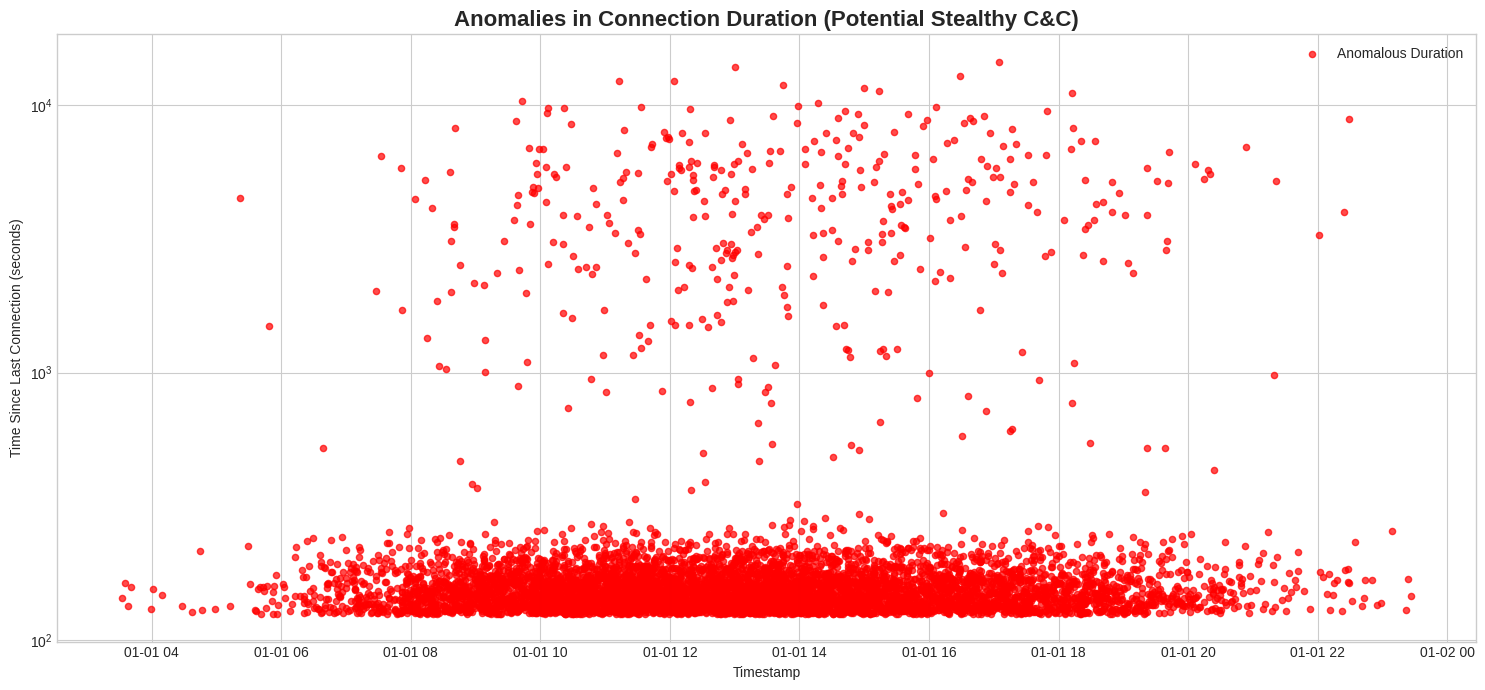

In [27]:
def plot_connection_duration_anomalies(siem):
    """
    Generates a scatter plot of connections with anomalously long intervals.
    """
    if siem.connection_duration_anomalies.empty:
        print("\nNote: No connection duration anomalies were detected to plot.")
        return
        
    anomalies = siem.connection_duration_anomalies
    
    top_duration_suspects = anomalies['src_ip'].value_counts().head(25)
    print("--- Top 25 Suspects by Count of Anomalous Duration Events ---")
    print("(These IPs use long, irregular intervals, possibly for stealthy C&C)")
    display(top_duration_suspects)

    anomalies_for_plot = anomalies.copy()
    anomalies_for_plot['timestamp_dt'] = pd.to_datetime(anomalies_for_plot['timestamp_sec'], unit='s')
    
    plt.figure(figsize=(15, 7))
    plt.scatter(anomalies_for_plot['timestamp_dt'], anomalies_for_plot['interval'], color='red', label='Anomalous Duration', s=20, alpha=0.7)
    
    plt.xlabel('Timestamp')
    plt.ylabel('Time Since Last Connection (seconds)')
    plt.title('Anomalies in Connection Duration (Potential Stealthy C&C)', fontsize=16, fontweight='bold')
    plt.legend()
    plt.yscale('log')
    plt.tight_layout()

plot_connection_duration_anomalies(siem)

### Negative Evidence: Defining Attacker Intent
A key part of the analysis is noting what the attackers were *not* doing. The extremely low upload-to-download ratio for all botnet clients (shown below) is inconsistent with data theft but is highly consistent with a credential stuffing attack, where small login attempts receive larger "Login Failed" page responses.

In [28]:
def plot_upload_volume_anomalies(siem):
    """
    Plots clients with the most high-volume outlier connections.
    """
    if siem.upload_volume_anomalies.empty:
        print("\nNote: No upload volume anomalies (Z-score > 3) were detected to plot.")
        return
        
    outlier_counts = siem.upload_volume_anomalies['src_ip'].value_counts().reset_index()
    outlier_counts.columns = ['src_ip', 'outlier_event_count']
    
    plt.figure(figsize=(14, 7))
    sns.barplot(data=outlier_counts.head(20), x='src_ip', y='outlier_event_count', palette='cividis_r')
    
    plt.ylabel('Number of High-Volume Outlier Events', fontsize=12)
    plt.xlabel('External Client IP', fontsize=12)
    plt.title('Clients with Statistically Anomalous Upload Spikes (Z-Score > 3)', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
plot_upload_volume_anomalies(siem)


Note: No upload volume anomalies (Z-score > 3) were detected to plot.


/tmp/ipykernel_35143/3620167506.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='src_ip', y='up_down_ratio', palette='inferno_r')


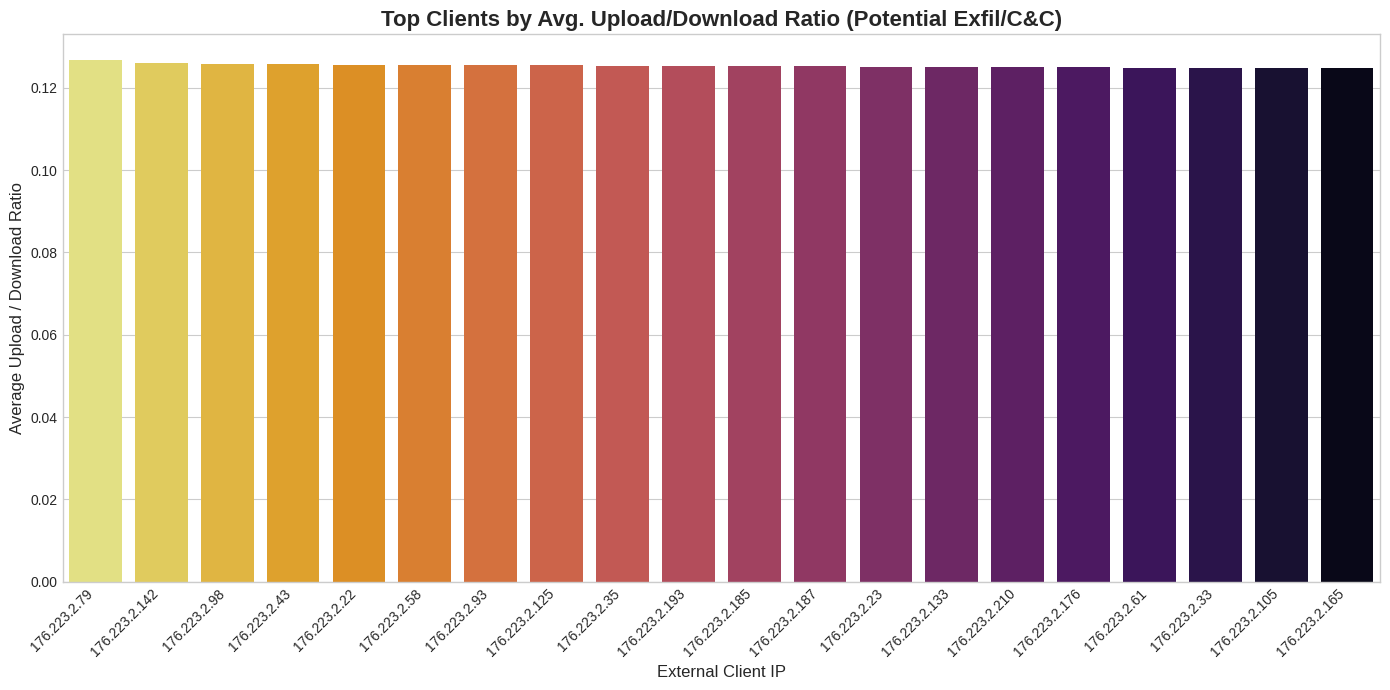

In [29]:
def plot_suspicious_ratios(siem):
    """
    Generates a bar plot of clients with the highest average upload/download ratio.
    """
    if siem.suspicious_up_down_ratios.empty:
        print("\nNote: No ratio data was generated to plot.")
        return
        
    df = siem.suspicious_up_down_ratios.head(20)
    
    plt.figure(figsize=(14, 7))
    sns.barplot(data=df, x='src_ip', y='up_down_ratio', palette='inferno_r')
    
    plt.ylabel('Average Upload / Download Ratio', fontsize=12)
    plt.xlabel('External Client IP', fontsize=12)
    plt.title('Top Clients by Avg. Upload/Download Ratio (Potential Exfil/C&C)', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plot_suspicious_ratios(siem)

### Threat Vector: Automated Bot Detection (Rhythmic Timing)
As with the internal C&C analysis, we can detect external bots by their machine-like, rhythmic connection patterns. A low standard deviation in connection intervals is a strong indicator of an automated script.

/tmp/ipykernel_35143/2901594508.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='src_ip', y='std', palette='Purples_r')


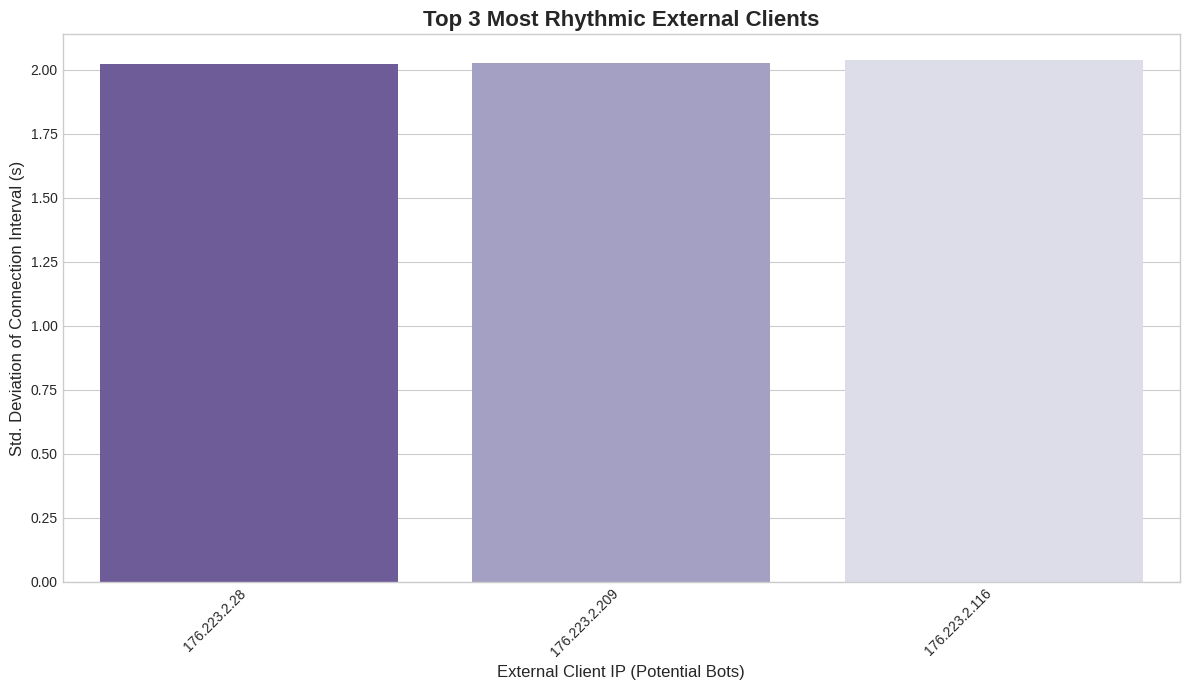

In [30]:
def plot_anomalous_timing(siem):
    """
    Generates a bar plot for the top most rhythmic external clients (potential bots).
    """
    if siem.anomalous_timing_candidates.empty:
        return

    df_plot = siem.anomalous_timing_candidates[
        siem.anomalous_timing_candidates['std'] < ANOMALOUS_TIMING_STD_DEV_THRESHOLD
    ].head(TOP_N_EXTERNAL_PLOT)

    if df_plot.empty:
        print("\nNote: No clients met the threshold for the Anomalous Timing (Bot) plot.")
        return

    plt.figure(figsize=(12, 7))
    sns.barplot(data=df_plot, x='src_ip', y='std', palette='Purples_r')
    
    plt.ylabel('Std. Deviation of Connection Interval (s)', fontsize=12)
    plt.xlabel('External Client IP (Potential Bots)', fontsize=12)
    plt.title(f'Top {len(df_plot)} Most Rhythmic External Clients', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plot_anomalous_timing(siem)

### Correlation Results: Identifying Coordinated External Attackers
By correlating all external threat vectors, we can identify the most suspicious source IPs. These are clients that trigger multiple detection rules, confirming their role in a multi-tactic attack.

In [31]:
def display_external_correlation_results(siem):
    """
    Displays the results from the external threat correlation engine.
    """
    print("\n" + "="*80)
    print("🚨 EXTERNAL THREAT CORRELATION ENGINE: RESULTS 🚨".center(80))
    print("="*80)

    if siem.external_correlation_scores.empty:
        print("\nNo correlated external threats were found.")
        print("="*80)
        return

    print("\n--- Top 50 Overall Suspects (by number of detection triggers) ---\n")
    display(siem.external_correlation_scores.head(50))

    if siem.active_and_stealthy_bots:
        print("\n--- HIGHLY SUSPICIOUS: Active 24/7 AND uses stealthy C&C ---")
        for ip in siem.active_and_stealthy_bots[:10]:
            print(f"  - {ip}")
            
    if siem.brute_force_and_stealthy_bots:
        print("\n--- HIGHLY SUSPICIOUS: Brute-Forcer AND uses stealthy C&C ---")
        for ip in siem.brute_force_and_stealthy_bots[:10]:
            print(f"  - {ip}")
    
    print("\n" + "="*80)

display_external_correlation_results(siem)


                🚨 EXTERNAL THREAT CORRELATION ENGINE: RESULTS 🚨                 

--- Top 50 Overall Suspects (by number of detection triggers) ---



src_ip  detection_score
1    176.223.2.158                4
4     176.223.2.26                4
22   176.223.2.174                4
18   176.223.2.165                4
11   176.223.2.206                4
54   176.223.2.153                4
63    176.223.2.32                4
50    176.223.2.37                4
21   176.223.2.203                4
34   176.223.2.207                4
37   176.223.2.176                4
108   176.223.2.76                4
110   176.223.2.85                4
104   176.223.2.44                4
105  176.223.2.121                4
96    176.223.2.19                4
93   176.223.2.172                4
92   176.223.2.150                4
193   176.223.2.71                4
167   176.223.2.52                4
174  176.223.2.111                4
145  176.223.2.163                4
147   176.223.2.64                4
171   176.223.2.30                4
192  176.223.2.188                4
126   176.223.2.18                4
127   176.223.2.25                4
79   176.223.2.113                4
71    176.223.2.56                4
84   176.223.2.115                4
60   176.223.2.162                3
26    176.223.2.55                3
30    176.223.2.59                3
27   176.223.2.147                3
14    176.223.2.36                3
55   176.223.2.108                3
48    176.223.2.81                3
69   176.223.2.154                3
76    176.223.2.60                3
78   176.223.2.148                3
83   176.223.2.137                3
91   176.223.2.118                3
95   176.223.2.186                3
111  176.223.2.130                3
124   176.223.2.74                3
128  176.223.2.107                3
131   176.223.2.77                3
132   176.223.2.13                3
129   176.223.2.65                3
88   176.223.2.157                3


--- HIGHLY SUSPICIOUS: Active 24/7 AND uses stealthy C&C ---
  - 176.223.2.38
  - 176.223.2.158
  - 176.223.2.129
  - 176.223.2.44
  - 176.223.2.26
  - 176.223.2.162
  - 176.223.2.121
  - 176.223.2.12
  - 176.223.2.206
  - 176.223.2.76

--- HIGHLY SUSPICIOUS: Brute-Forcer AND uses stealthy C&C ---
  - 176.223.2.108
  - 176.223.2.158
  - 176.223.2.44
  - 176.223.2.26
  - 176.223.2.121
  - 176.223.2.92
  - 176.223.2.91
  - 176.223.2.206
  - 176.223.2.32
  - 176.223.2.76



### Deep Dive: Forensic Analysis of Top 10 External Suspects
To gain deeper insight, we perform a detailed forensic analysis of the top 10 most suspicious external IPs. For each IP, we examine their traffic statistics, targeted services, and connection frequency over time.

Starting detailed analysis for the following top 10 IPs: ['176.223.2.158', '176.223.2.26', '176.223.2.174', '176.223.2.165', '176.223.2.206', '176.223.2.153', '176.223.2.32', '176.223.2.37', '176.223.2.203', '176.223.2.207']

                   ### FORENSIC ANALYSIS FOR SUSPECT IP: 176.223.2.158                    

--- Basic Traffic Statistics for 176.223.2.158 ---


up_bytes                   7.453640e+07
down_bytes                 6.351087e+08
total_connections          6.546000e+03
avg_up_bytes_per_conn      1.138656e+04
avg_down_bytes_per_conn    9.702241e+04
dtype: float64


--- Top Ports Targeted by 176.223.2.158 ---


port
443    6546
Name: count, dtype: int64


--- Top Internal Servers Targeted by 176.223.2.158 ---


dst_ip
200.0.0.12    6546
Name: count, dtype: int64


--- Visual Forensic Dashboard for 176.223.2.158 ---


/tmp/ipykernel_35143/113520594.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_per_minute = suspect_df.set_index('timestamp_dt').resample('T').size()


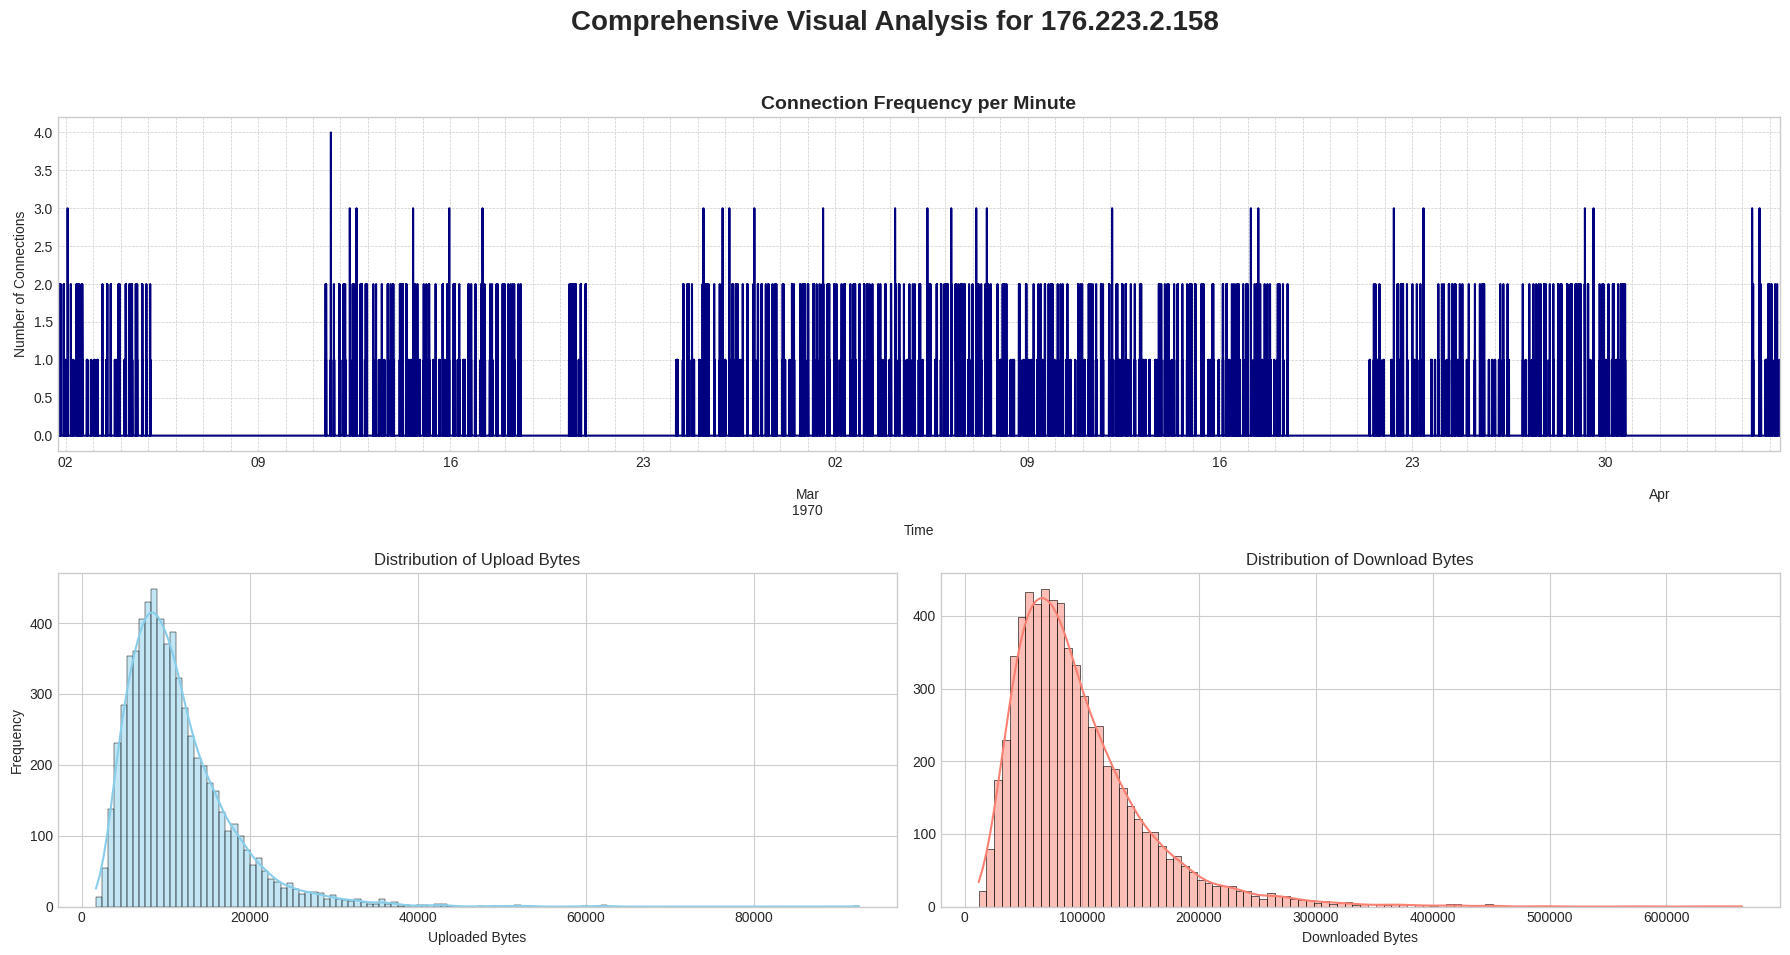


--- Recommended Next Step for 176.223.2.158 ---
Manually investigate this IP on threat intelligence platforms like VirusTotal and AbuseIPDB.

                    ### FORENSIC ANALYSIS FOR SUSPECT IP: 176.223.2.26                    

--- Basic Traffic Statistics for 176.223.2.26 ---


up_bytes                   6.815466e+07
down_bytes                 5.801552e+08
total_connections          6.069000e+03
avg_up_bytes_per_conn      1.122997e+04
avg_down_bytes_per_conn    9.559322e+04
dtype: float64


--- Top Ports Targeted by 176.223.2.26 ---


port
443    6069
Name: count, dtype: int64


--- Top Internal Servers Targeted by 176.223.2.26 ---


dst_ip
200.0.0.12    6069
Name: count, dtype: int64


--- Visual Forensic Dashboard for 176.223.2.26 ---


/tmp/ipykernel_35143/113520594.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_per_minute = suspect_df.set_index('timestamp_dt').resample('T').size()


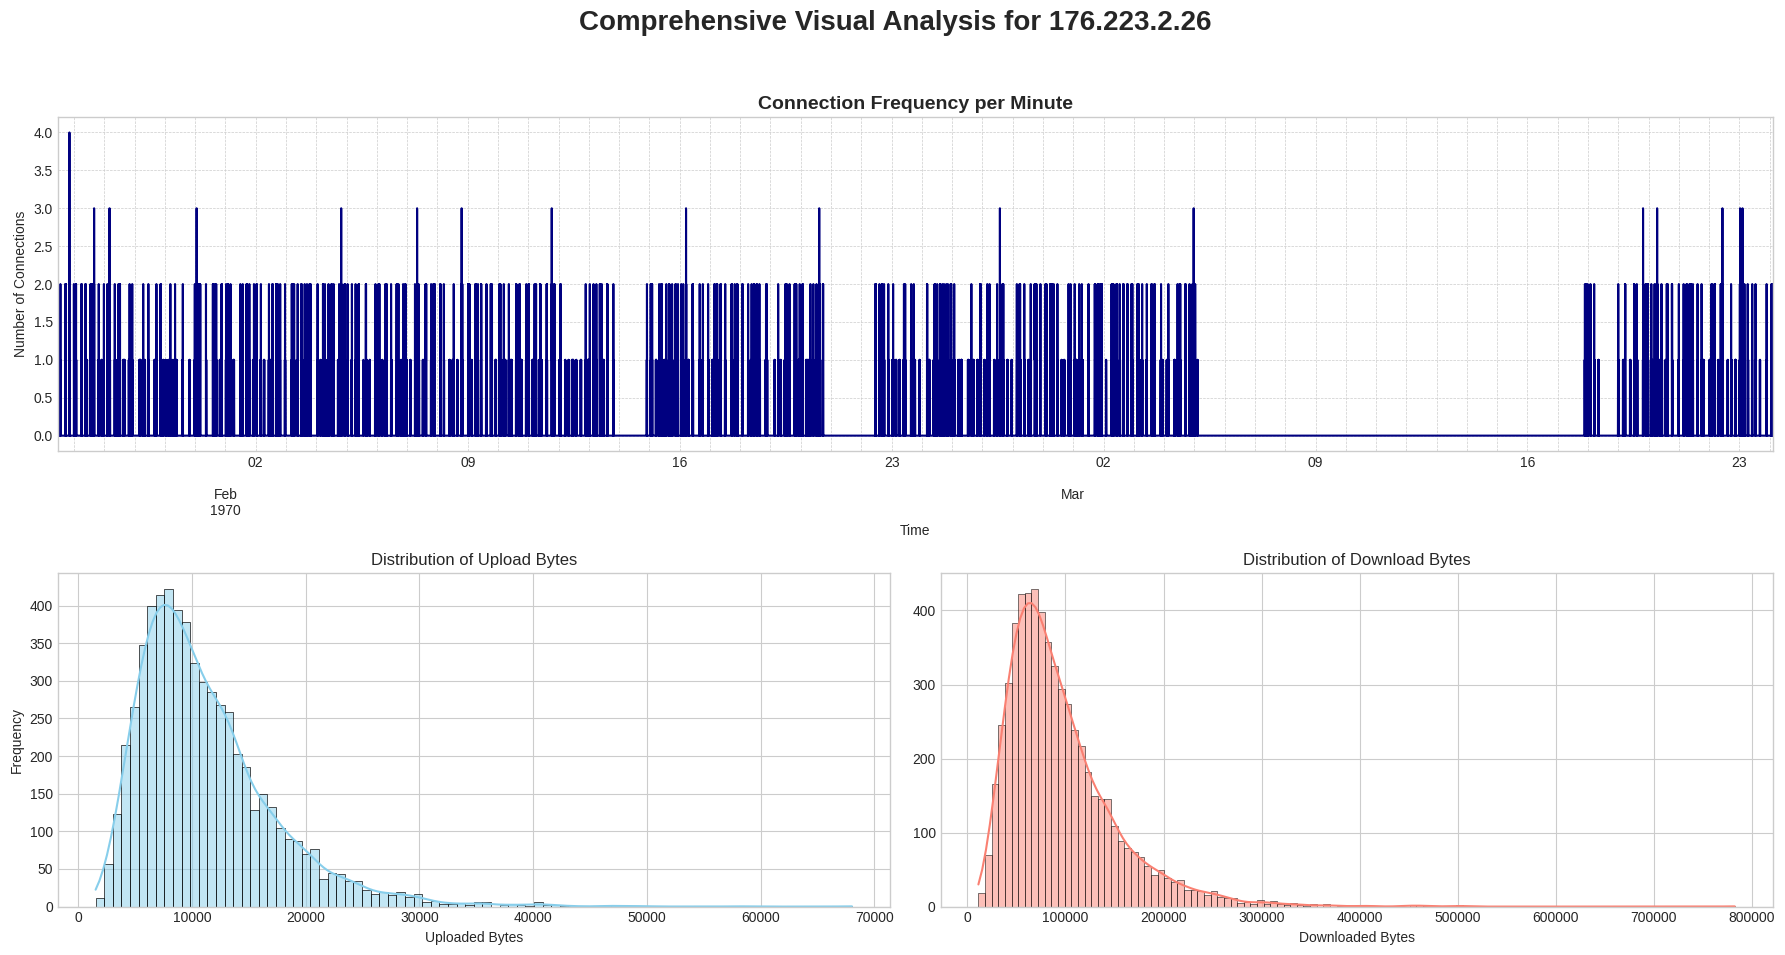


--- Recommended Next Step for 176.223.2.26 ---
Manually investigate this IP on threat intelligence platforms like VirusTotal and AbuseIPDB.

                   ### FORENSIC ANALYSIS FOR SUSPECT IP: 176.223.2.174                    

--- Basic Traffic Statistics for 176.223.2.174 ---


up_bytes                   9.015024e+07
down_bytes                 7.635787e+08
total_connections          7.942000e+03
avg_up_bytes_per_conn      1.135107e+04
avg_down_bytes_per_conn    9.614438e+04
dtype: float64


--- Top Ports Targeted by 176.223.2.174 ---


port
443    7942
Name: count, dtype: int64


--- Top Internal Servers Targeted by 176.223.2.174 ---


dst_ip
200.0.0.12    7942
Name: count, dtype: int64


--- Visual Forensic Dashboard for 176.223.2.174 ---


/tmp/ipykernel_35143/113520594.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_per_minute = suspect_df.set_index('timestamp_dt').resample('T').size()


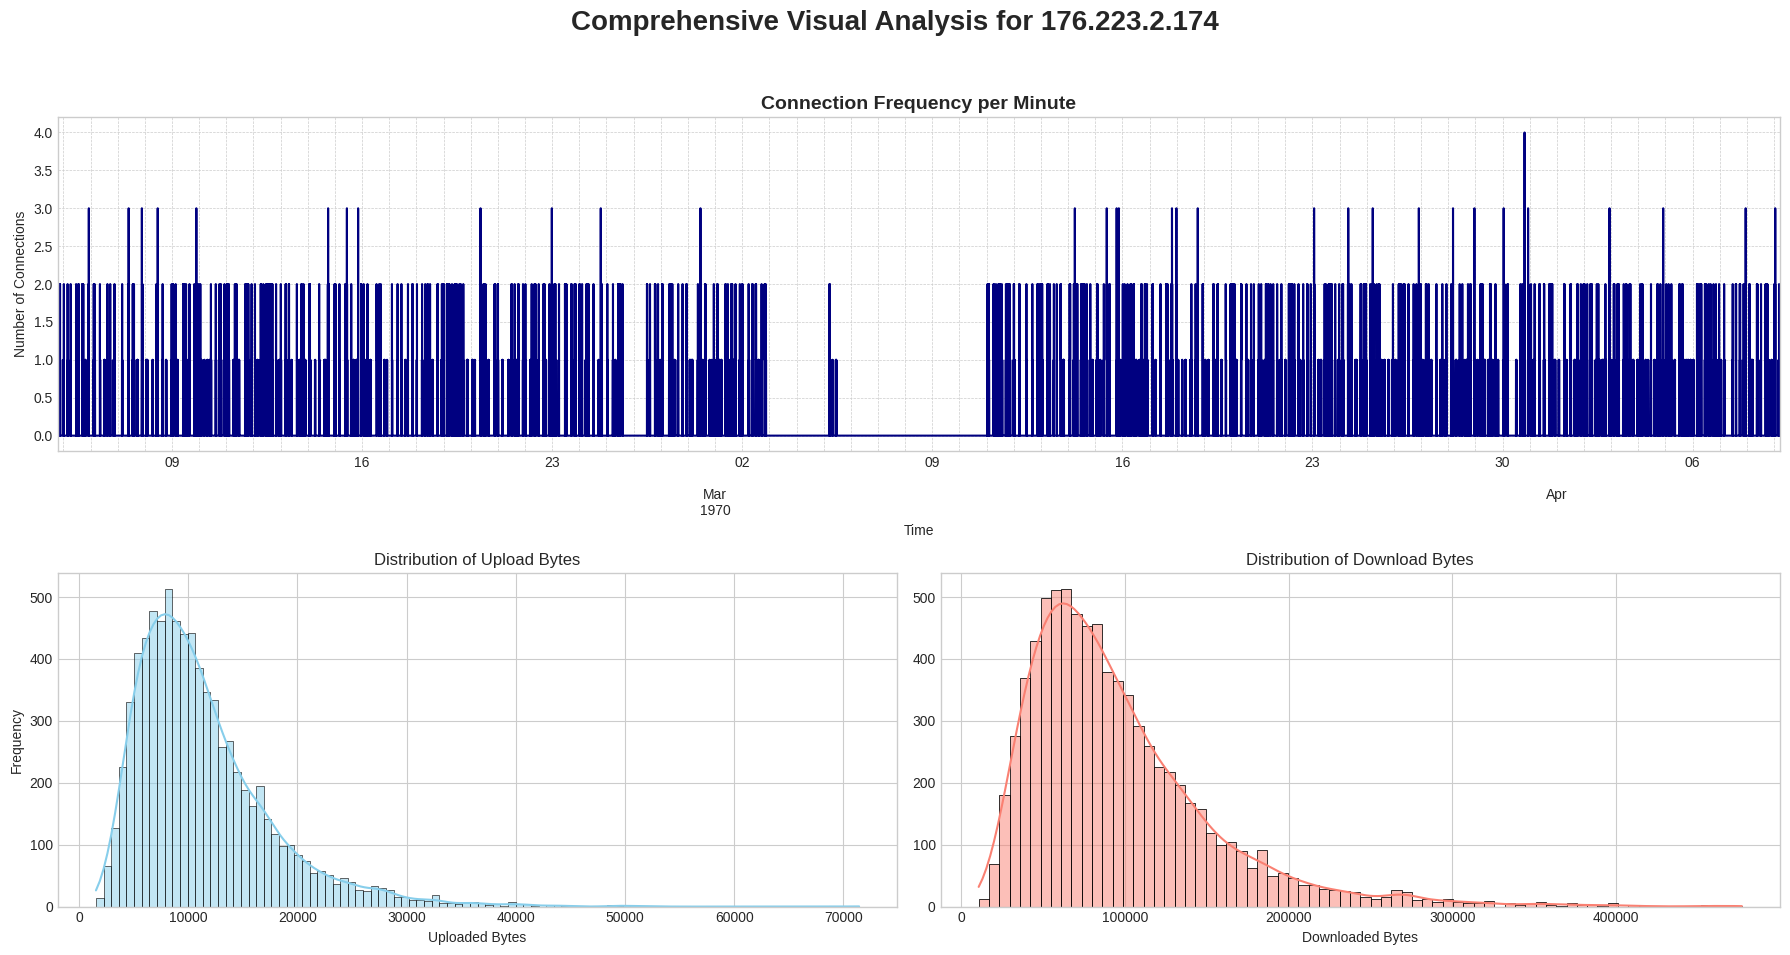


--- Recommended Next Step for 176.223.2.174 ---
Manually investigate this IP on threat intelligence platforms like VirusTotal and AbuseIPDB.

                   ### FORENSIC ANALYSIS FOR SUSPECT IP: 176.223.2.165                    

--- Basic Traffic Statistics for 176.223.2.165 ---


up_bytes                   6.719614e+07
down_bytes                 5.680740e+08
total_connections          5.914000e+03
avg_up_bytes_per_conn      1.136221e+04
avg_down_bytes_per_conn    9.605581e+04
dtype: float64


--- Top Ports Targeted by 176.223.2.165 ---


port
443    5914
Name: count, dtype: int64


--- Top Internal Servers Targeted by 176.223.2.165 ---


dst_ip
200.0.0.11    5914
Name: count, dtype: int64


--- Visual Forensic Dashboard for 176.223.2.165 ---


/tmp/ipykernel_35143/113520594.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_per_minute = suspect_df.set_index('timestamp_dt').resample('T').size()


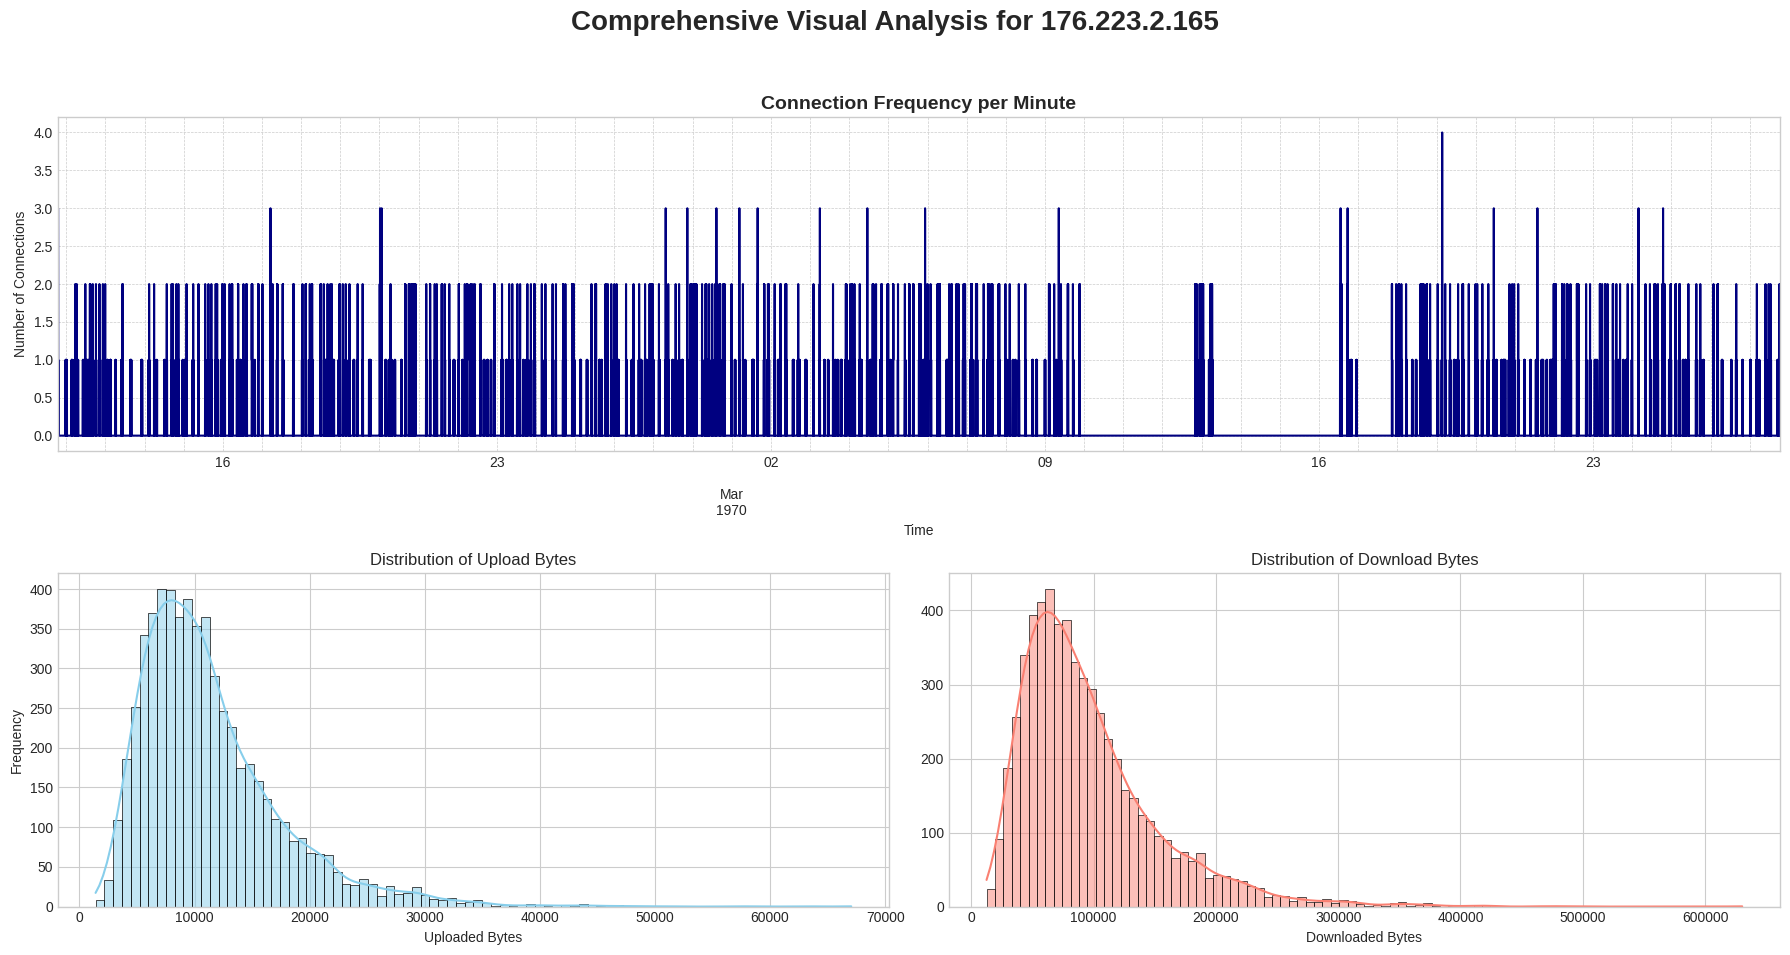


--- Recommended Next Step for 176.223.2.165 ---
Manually investigate this IP on threat intelligence platforms like VirusTotal and AbuseIPDB.

                   ### FORENSIC ANALYSIS FOR SUSPECT IP: 176.223.2.206                    

--- Basic Traffic Statistics for 176.223.2.206 ---


up_bytes                   6.438330e+07
down_bytes                 5.502136e+08
total_connections          5.657000e+03
avg_up_bytes_per_conn      1.138117e+04
avg_down_bytes_per_conn    9.726244e+04
dtype: float64


--- Top Ports Targeted by 176.223.2.206 ---


port
443    5657
Name: count, dtype: int64


--- Top Internal Servers Targeted by 176.223.2.206 ---


dst_ip
200.0.0.12    5657
Name: count, dtype: int64


--- Visual Forensic Dashboard for 176.223.2.206 ---


/tmp/ipykernel_35143/113520594.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_per_minute = suspect_df.set_index('timestamp_dt').resample('T').size()


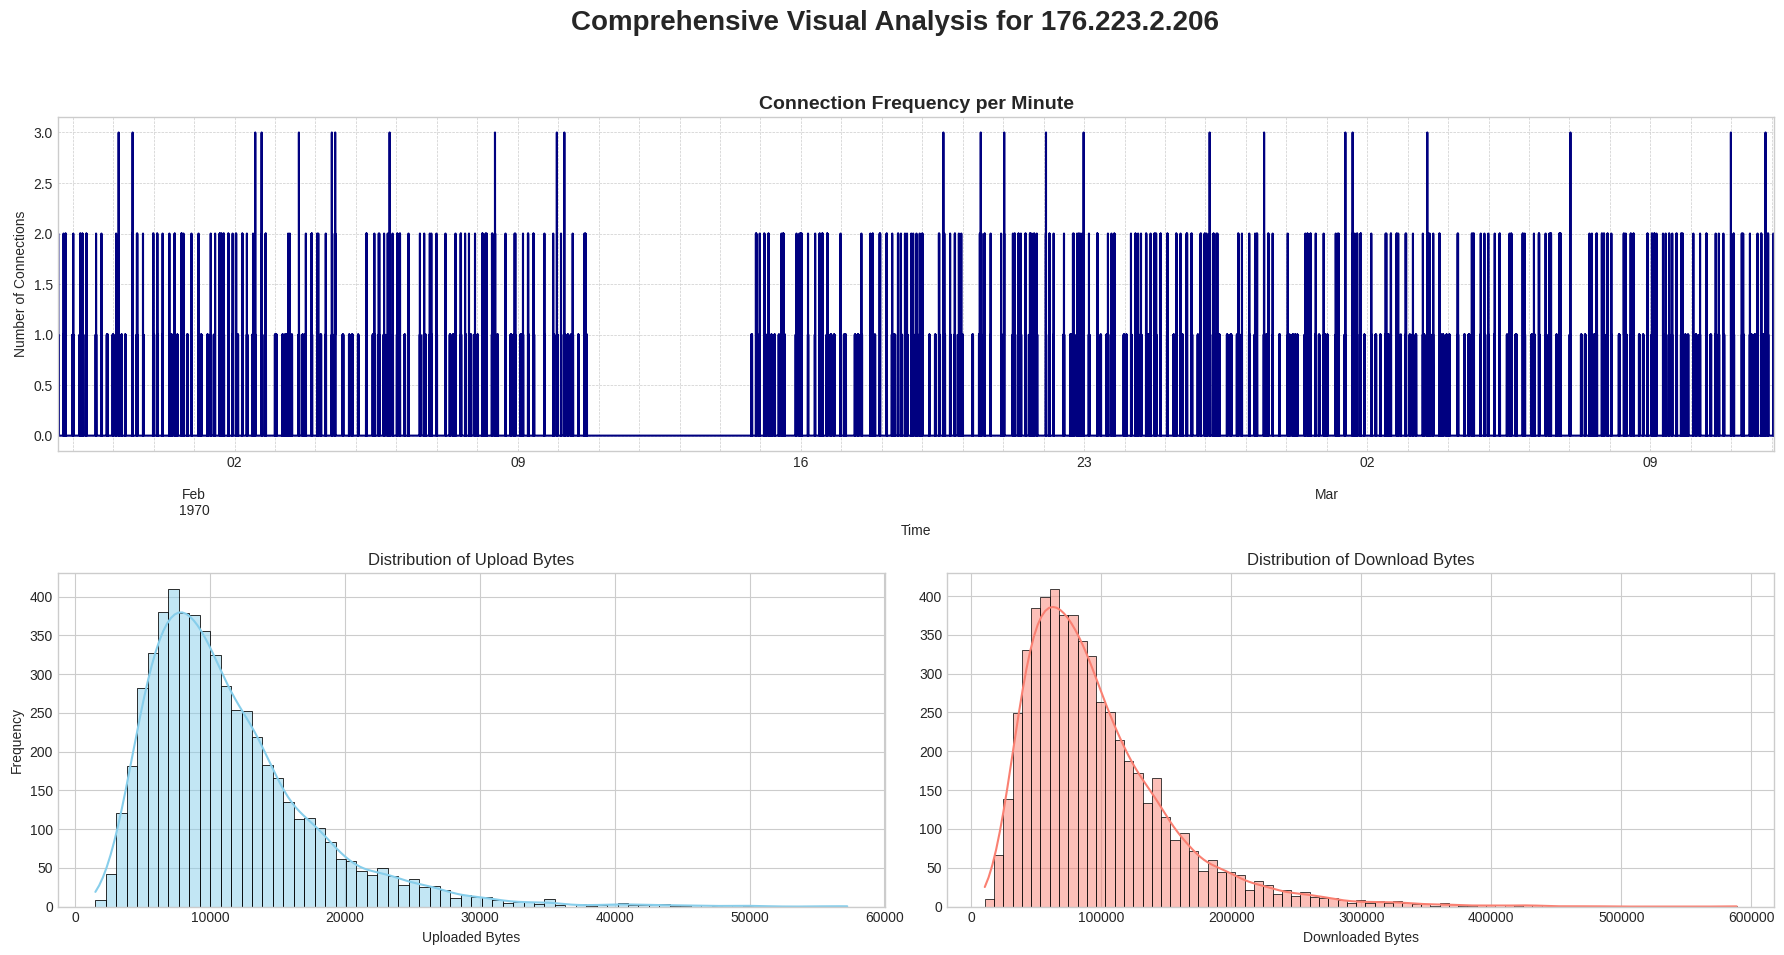


--- Recommended Next Step for 176.223.2.206 ---
Manually investigate this IP on threat intelligence platforms like VirusTotal and AbuseIPDB.

                   ### FORENSIC ANALYSIS FOR SUSPECT IP: 176.223.2.153                    

--- Basic Traffic Statistics for 176.223.2.153 ---


up_bytes                   7.766616e+07
down_bytes                 6.608605e+08
total_connections          6.844000e+03
avg_up_bytes_per_conn      1.134807e+04
avg_down_bytes_per_conn    9.656056e+04
dtype: float64


--- Top Ports Targeted by 176.223.2.153 ---


port
443    6844
Name: count, dtype: int64


--- Top Internal Servers Targeted by 176.223.2.153 ---


dst_ip
200.0.0.11    6844
Name: count, dtype: int64


--- Visual Forensic Dashboard for 176.223.2.153 ---


/tmp/ipykernel_35143/113520594.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_per_minute = suspect_df.set_index('timestamp_dt').resample('T').size()


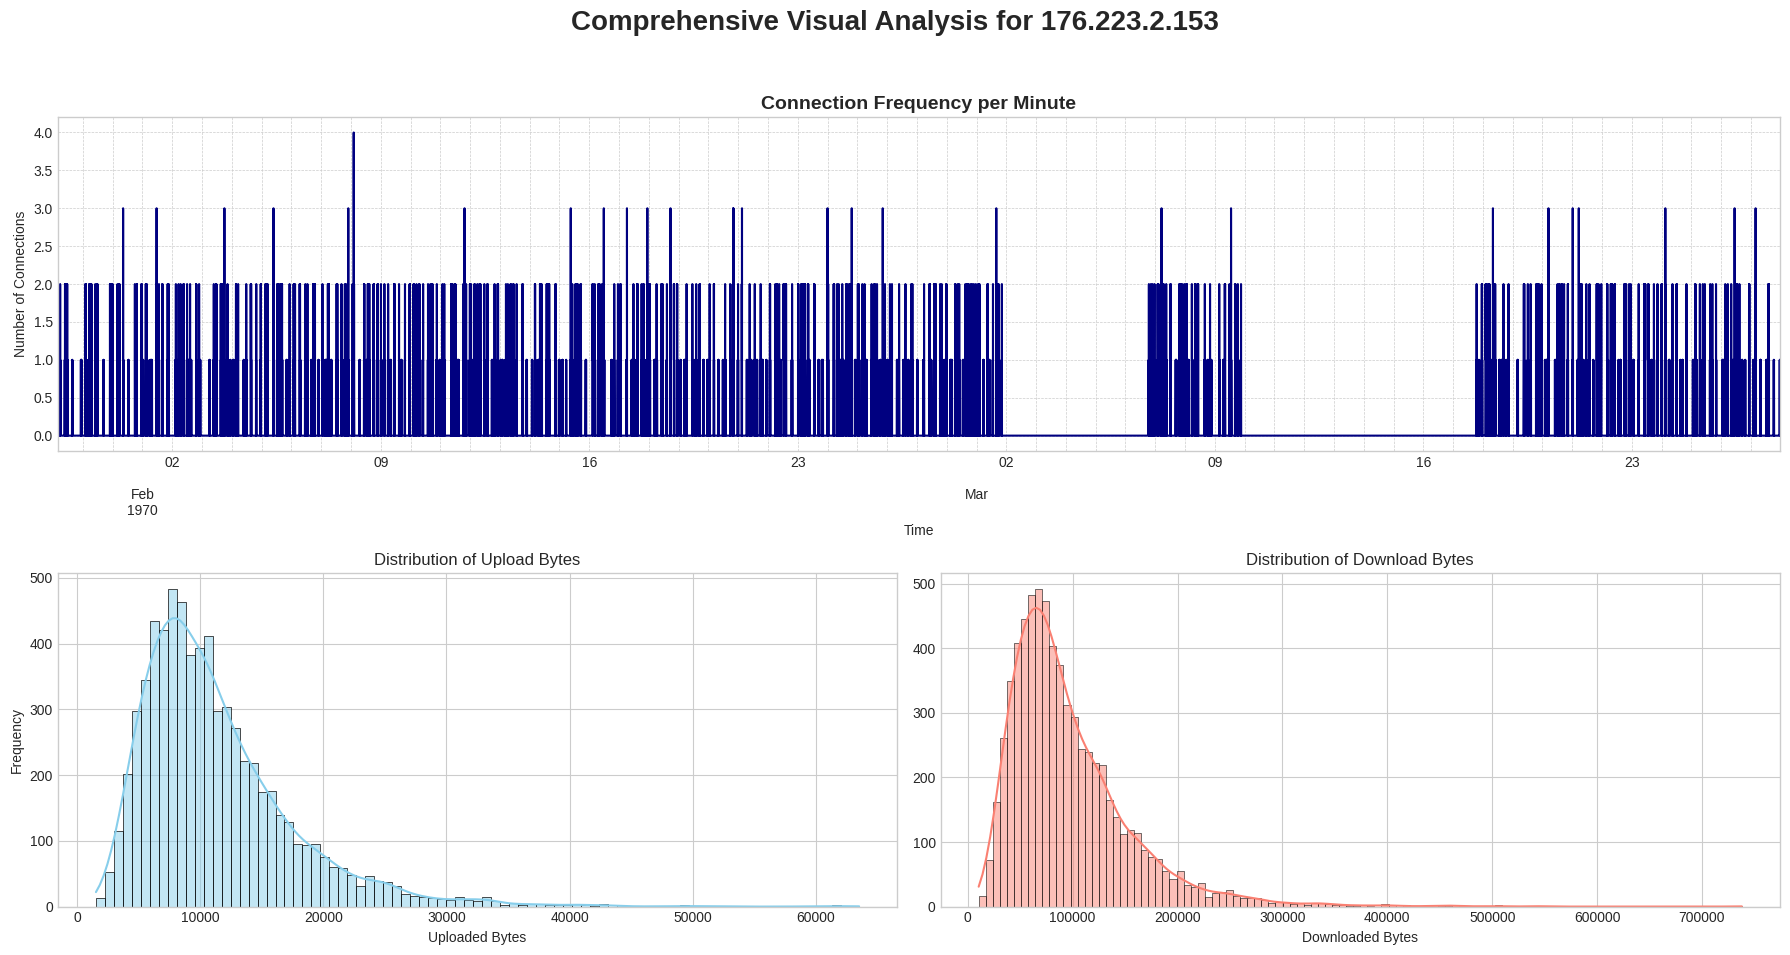


--- Recommended Next Step for 176.223.2.153 ---
Manually investigate this IP on threat intelligence platforms like VirusTotal and AbuseIPDB.

                    ### FORENSIC ANALYSIS FOR SUSPECT IP: 176.223.2.32                    

--- Basic Traffic Statistics for 176.223.2.32 ---


up_bytes                   5.481869e+07
down_bytes                 4.653685e+08
total_connections          4.914000e+03
avg_up_bytes_per_conn      1.115561e+04
avg_down_bytes_per_conn    9.470259e+04
dtype: float64


--- Top Ports Targeted by 176.223.2.32 ---


port
443    4914
Name: count, dtype: int64


--- Top Internal Servers Targeted by 176.223.2.32 ---


dst_ip
200.0.0.12    4914
Name: count, dtype: int64


--- Visual Forensic Dashboard for 176.223.2.32 ---


/tmp/ipykernel_35143/113520594.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_per_minute = suspect_df.set_index('timestamp_dt').resample('T').size()


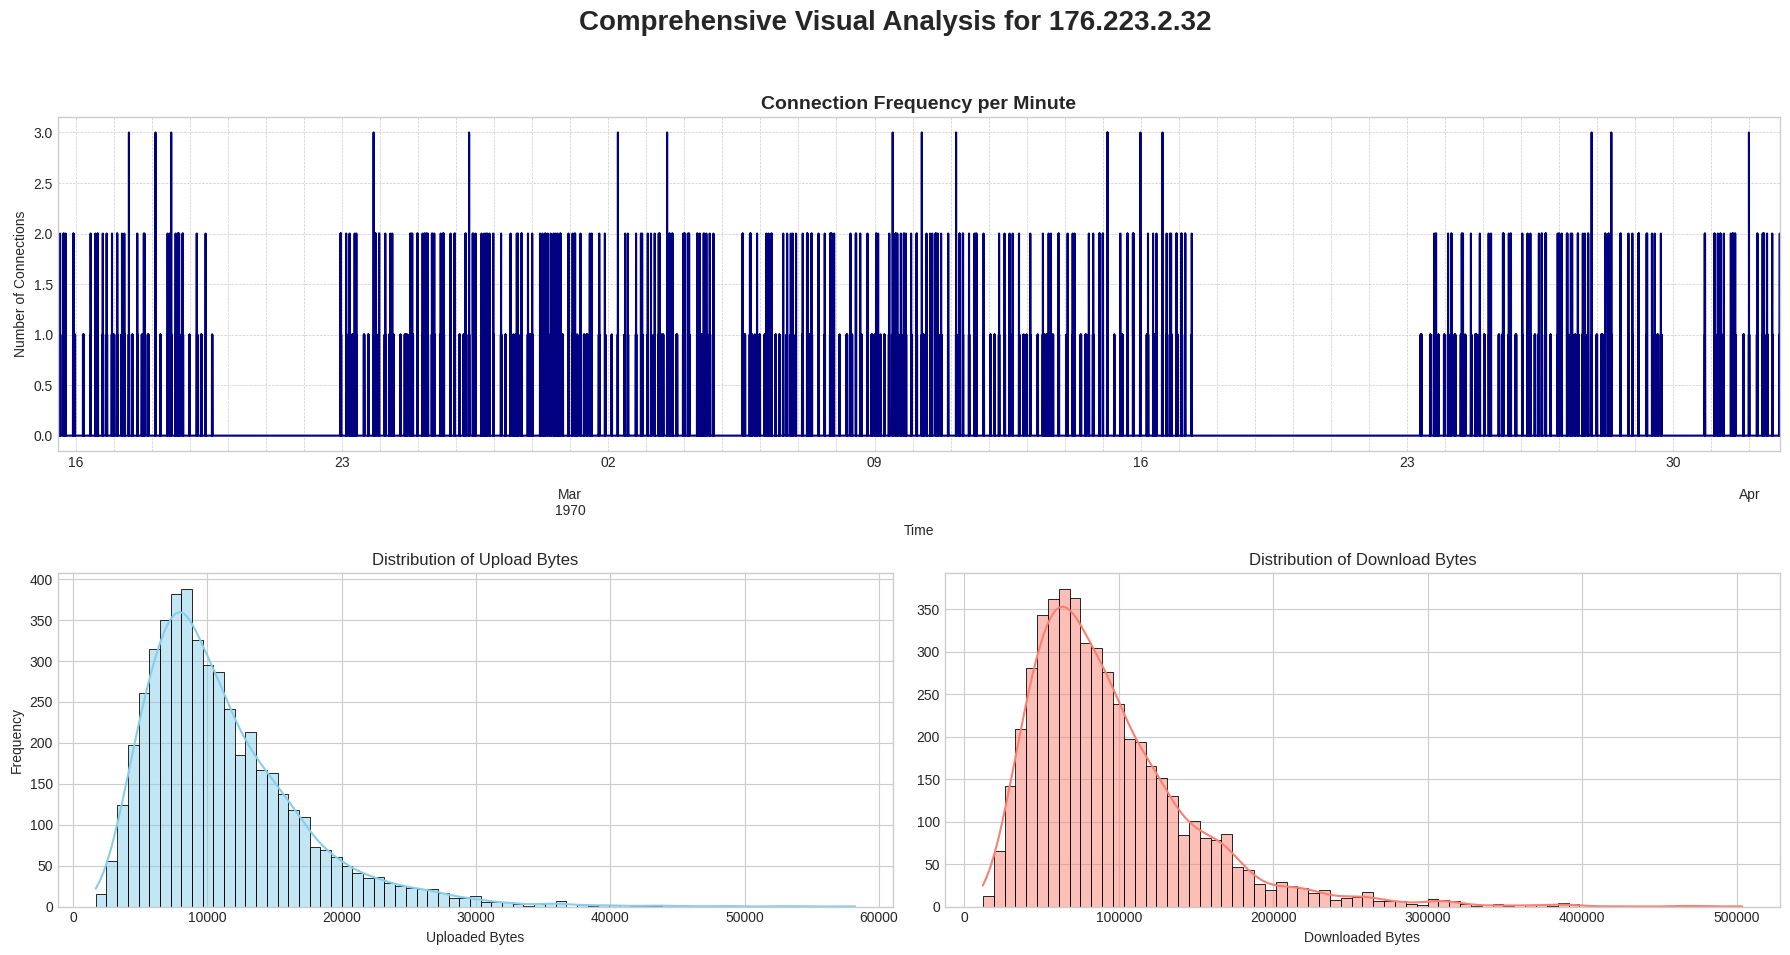


--- Recommended Next Step for 176.223.2.32 ---
Manually investigate this IP on threat intelligence platforms like VirusTotal and AbuseIPDB.

                    ### FORENSIC ANALYSIS FOR SUSPECT IP: 176.223.2.37                    

--- Basic Traffic Statistics for 176.223.2.37 ---


up_bytes                   5.676154e+07
down_bytes                 4.850173e+08
total_connections          4.999000e+03
avg_up_bytes_per_conn      1.135458e+04
avg_down_bytes_per_conn    9.702286e+04
dtype: float64


--- Top Ports Targeted by 176.223.2.37 ---


port
443    4999
Name: count, dtype: int64


--- Top Internal Servers Targeted by 176.223.2.37 ---


dst_ip
200.0.0.11    4999
Name: count, dtype: int64


--- Visual Forensic Dashboard for 176.223.2.37 ---


/tmp/ipykernel_35143/113520594.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_per_minute = suspect_df.set_index('timestamp_dt').resample('T').size()


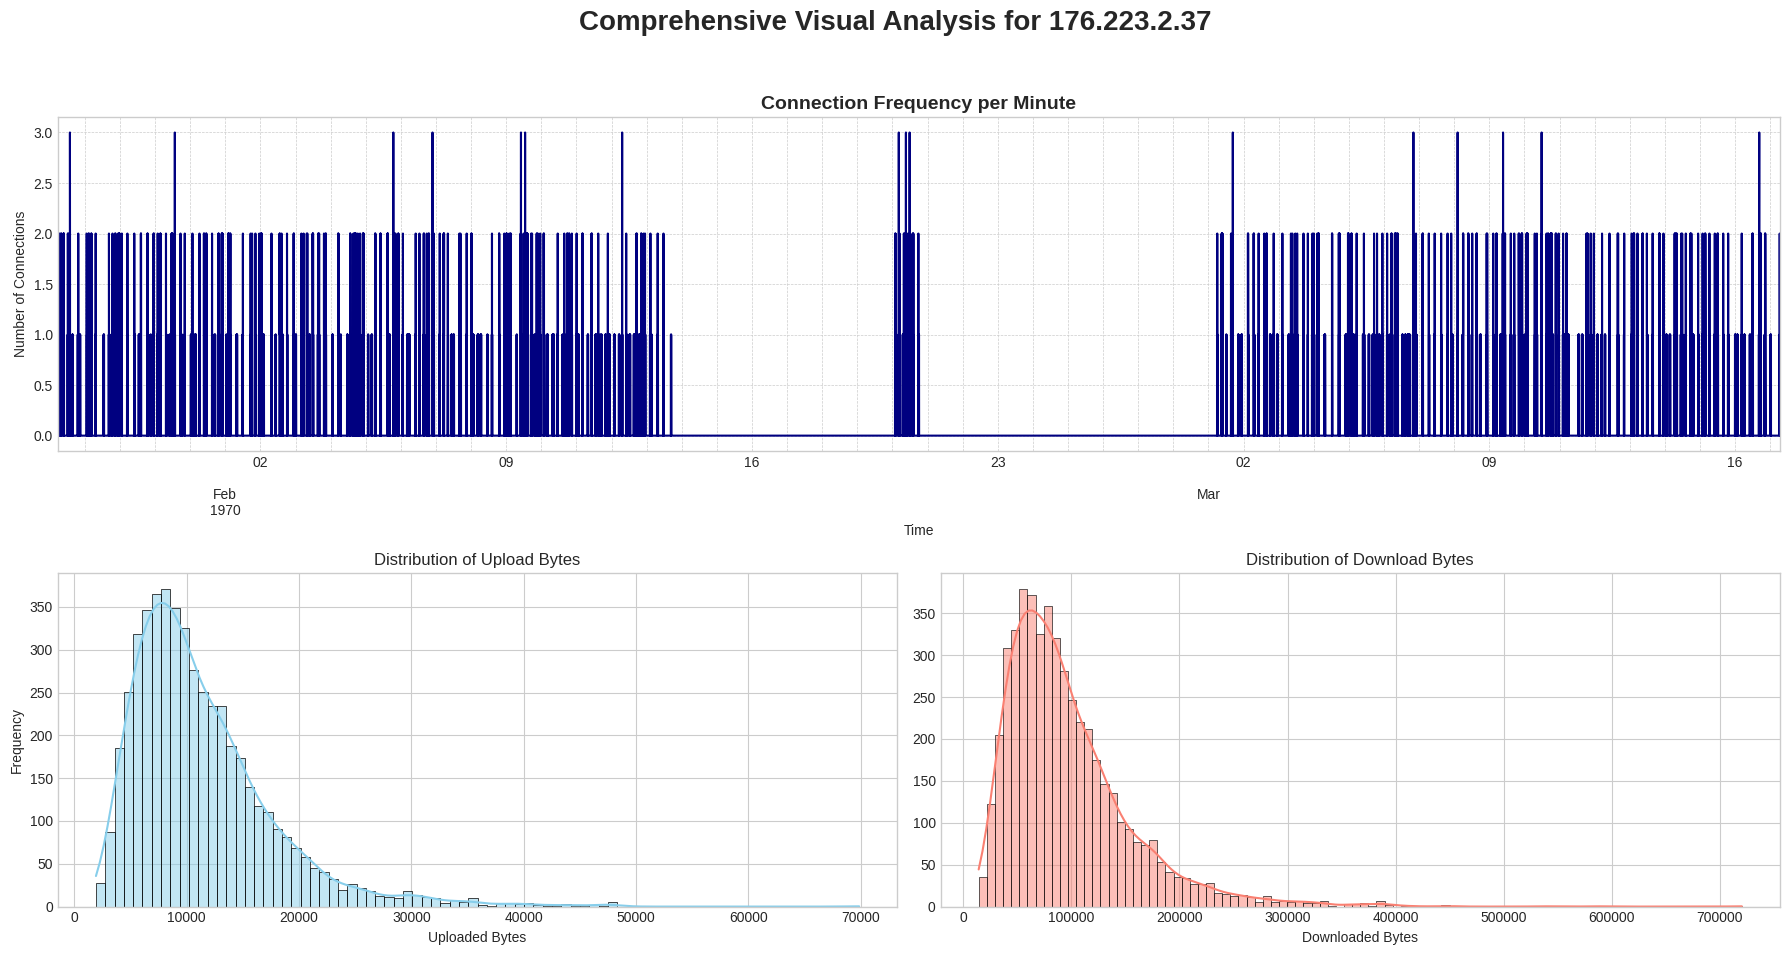


--- Recommended Next Step for 176.223.2.37 ---
Manually investigate this IP on threat intelligence platforms like VirusTotal and AbuseIPDB.

                   ### FORENSIC ANALYSIS FOR SUSPECT IP: 176.223.2.203                    

--- Basic Traffic Statistics for 176.223.2.203 ---


up_bytes                   5.301112e+07
down_bytes                 4.486178e+08
total_connections          4.708000e+03
avg_up_bytes_per_conn      1.125980e+04
avg_down_bytes_per_conn    9.528839e+04
dtype: float64


--- Top Ports Targeted by 176.223.2.203 ---


port
443    4708
Name: count, dtype: int64


--- Top Internal Servers Targeted by 176.223.2.203 ---


dst_ip
200.0.0.11    4708
Name: count, dtype: int64


--- Visual Forensic Dashboard for 176.223.2.203 ---


/tmp/ipykernel_35143/113520594.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_per_minute = suspect_df.set_index('timestamp_dt').resample('T').size()


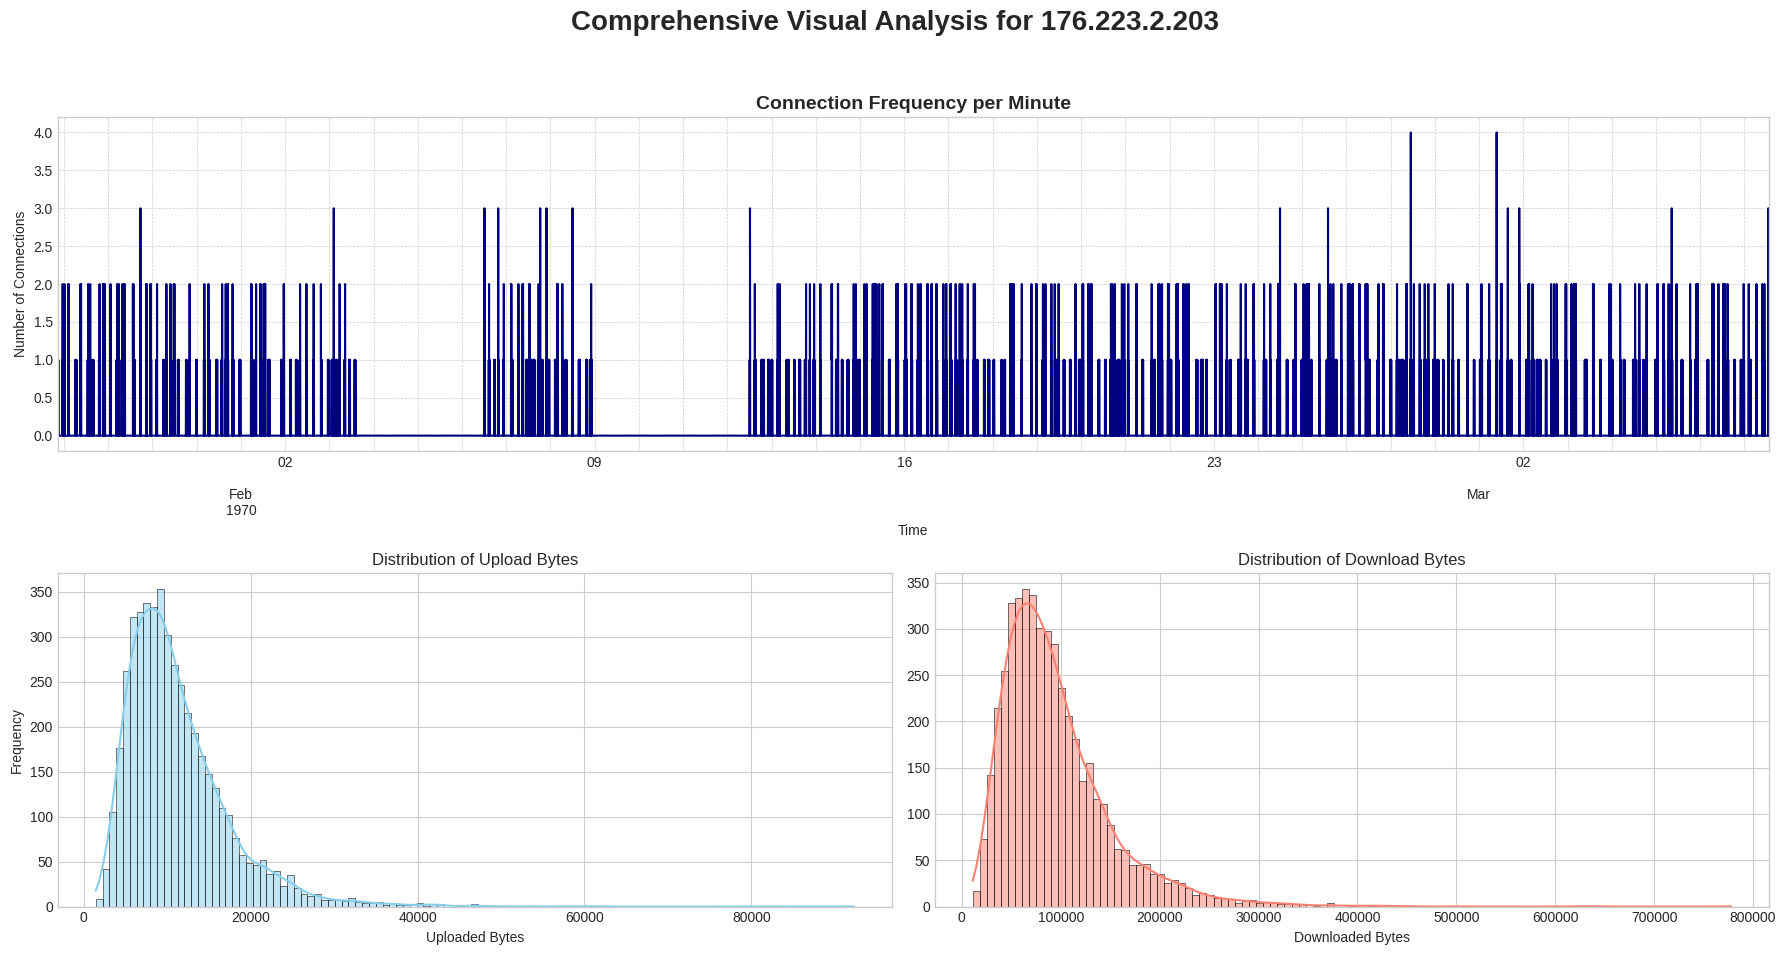


--- Recommended Next Step for 176.223.2.203 ---
Manually investigate this IP on threat intelligence platforms like VirusTotal and AbuseIPDB.

                   ### FORENSIC ANALYSIS FOR SUSPECT IP: 176.223.2.207                    

--- Basic Traffic Statistics for 176.223.2.207 ---


up_bytes                   5.605643e+07
down_bytes                 4.738894e+08
total_connections          4.962000e+03
avg_up_bytes_per_conn      1.129714e+04
avg_down_bytes_per_conn    9.550371e+04
dtype: float64


--- Top Ports Targeted by 176.223.2.207 ---


port
443    4962
Name: count, dtype: int64


--- Top Internal Servers Targeted by 176.223.2.207 ---


dst_ip
200.0.0.12    4962
Name: count, dtype: int64


--- Visual Forensic Dashboard for 176.223.2.207 ---


/tmp/ipykernel_35143/113520594.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_per_minute = suspect_df.set_index('timestamp_dt').resample('T').size()


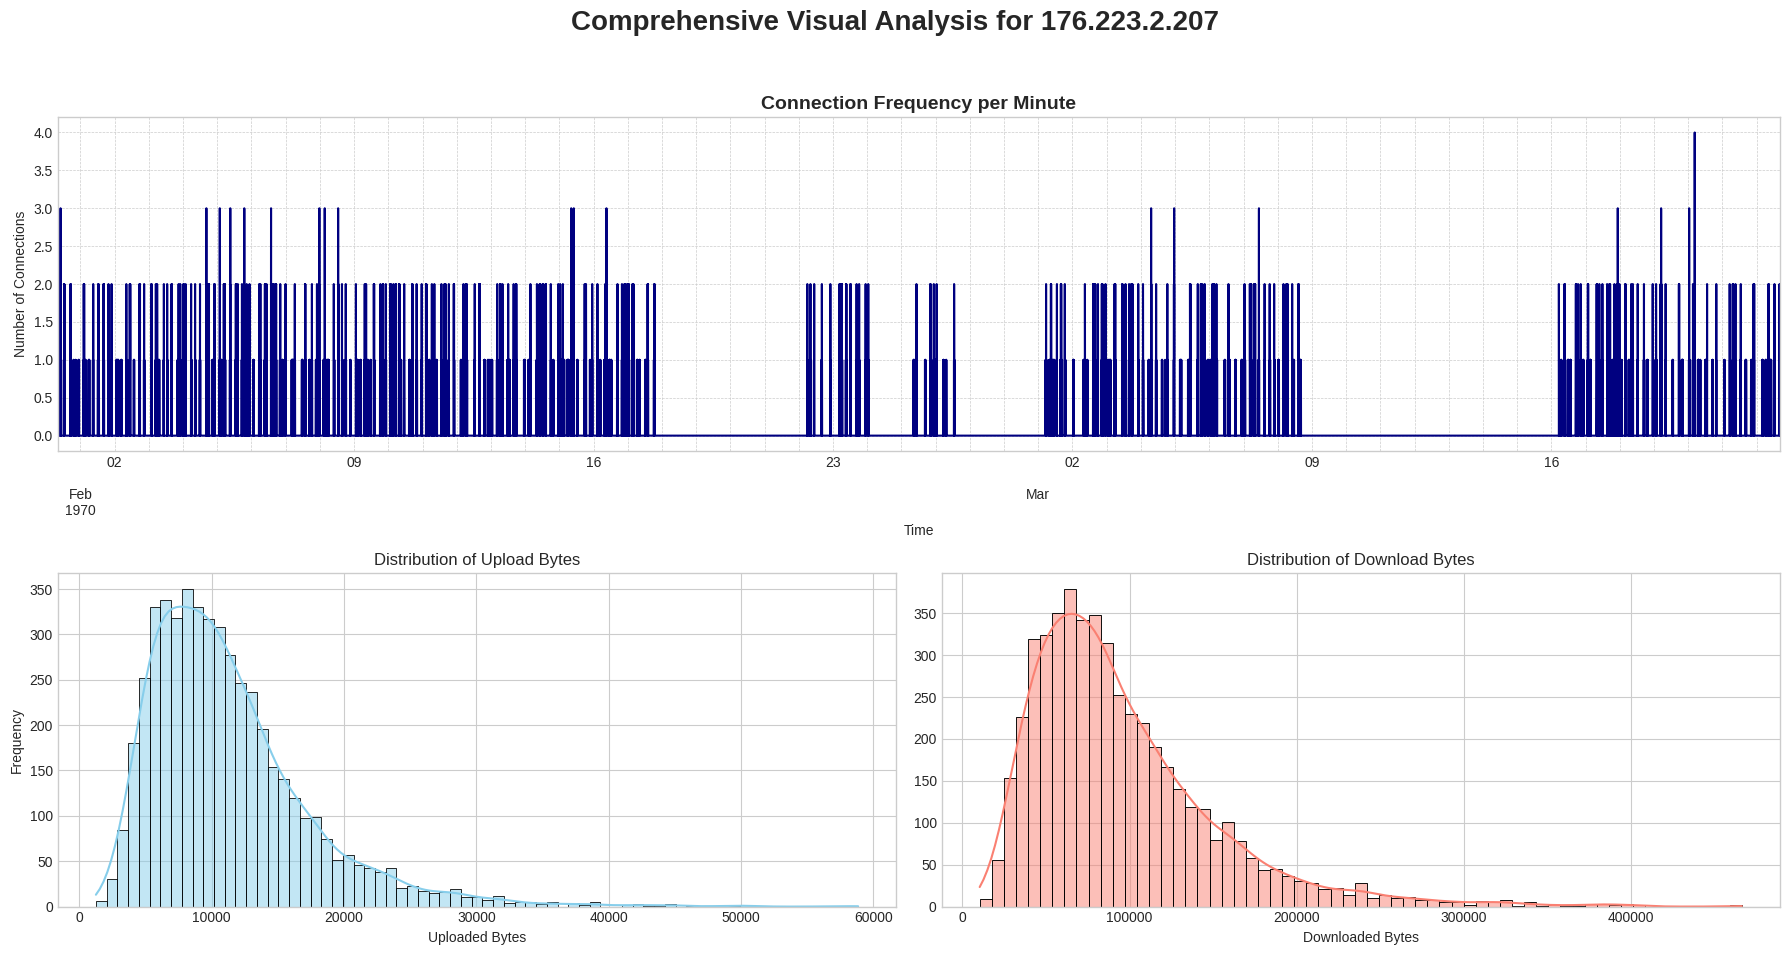


--- Recommended Next Step for 176.223.2.207 ---
Manually investigate this IP on threat intelligence platforms like VirusTotal and AbuseIPDB.


In [32]:
if not siem.external_correlation_scores.empty:
    top_10_suspect_ips = siem.external_correlation_scores.head(10)['src_ip'].tolist()
    print(f"Starting detailed analysis for the following top 10 IPs: {top_10_suspect_ips}")

    for ip_address in top_10_suspect_ips:
        
        print("\n" + "="*90)
        print(f" ### FORENSIC ANALYSIS FOR SUSPECT IP: {ip_address} ".center(90))
        print("="*90 + "\n")

        suspect_df = siem.servers_df[siem.servers_df['src_ip'] == ip_address].copy()
        suspect_df['timestamp_dt'] = pd.to_datetime(suspect_df['timestamp'], unit='s')

        if suspect_df.empty:
            print("No traffic data found for this IP. Skipping.")
            continue

        print(f"--- Basic Traffic Statistics for {ip_address} ---")
        total_stats = suspect_df.agg({'up_bytes': 'sum', 'down_bytes': 'sum', 'timestamp': 'count'}).rename({'timestamp': 'total_connections'})
        total_stats['avg_up_bytes_per_conn'] = total_stats['up_bytes'] / total_stats['total_connections']
        total_stats['avg_down_bytes_per_conn'] = total_stats['down_bytes'] / total_stats['total_connections']
        display(total_stats)

        print(f"\n--- Top Ports Targeted by {ip_address} ---")
        display(suspect_df['port'].value_counts().head(3))
        print(f"\n--- Top Internal Servers Targeted by {ip_address} ---")
        display(suspect_df['dst_ip'].value_counts().head(3))
        
        print(f"\n--- Visual Forensic Dashboard for {ip_address} ---")
        
        fig = plt.figure(figsize=(18, 10))
        gs = fig.add_gridspec(2, 2)

        ax1 = fig.add_subplot(gs[0, :])
        traffic_per_minute = suspect_df.set_index('timestamp_dt').resample('T').size()
        traffic_per_minute.plot(ax=ax1, color='navy')
        ax1.set_title('Connection Frequency per Minute', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Number of Connections')
        ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

        ax2 = fig.add_subplot(gs[1, 0])
        sns.histplot(suspect_df['up_bytes'], ax=ax2, kde=True, color='skyblue').set_title('Distribution of Upload Bytes')
        ax2.set_xlabel('Uploaded Bytes')
        ax2.set_ylabel('Frequency')

        ax3 = fig.add_subplot(gs[1, 1])
        sns.histplot(suspect_df['down_bytes'], ax=ax3, kde=True, color='salmon').set_title('Distribution of Download Bytes')
        ax3.set_xlabel('Downloaded Bytes')
        ax3.set_ylabel('')

        fig.suptitle(f'Comprehensive Visual Analysis for {ip_address}', fontsize=20, fontweight='bold')
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        print(f"\n--- Recommended Next Step for {ip_address} ---")
        print("Manually investigate this IP on threat intelligence platforms like VirusTotal and AbuseIPDB.")

else:
    print("No external suspects found to perform a deep-dive analysis.")

## Final Report and Actionable Intelligence
The final report consolidates all findings, providing a ranked list of the most critical internal and external threats along with the specific reasons for their flagging. This serves as an summary for the incident response team, clearly identifying which machines to isolate first and which external IPs to block.

In [33]:
# Print the summary report
siem.generate_final_report()


            🚨 SIEM REPORT: POTENTIALLY ANOMALOUS INTERNAL DEVICES 🚨             

Found 58 potentially anomalous internal device(s):

--- DEVICE: 192.168.110.149 | Suspicion Score: 317 ---
  - CRITICAL COMBO: Score multiplied by 1.5x.
  - Lateral Movement (Scanning): Initiated new connections to 6 unique internal hosts.
  - Anomalous Activity (Spike): Connection count to 192.168.110.224 on port 443 spiked by 130.0x.
  - Anomalous Activity (Spike): Connection count to 192.168.110.230 on port 53 spiked by 156.0x.
  - Anomalous Activity (Spike): Connection count to 192.168.110.231 on port 443 spiked by 103.0x.
  - Anomalous Activity (Spike): Connection count to 192.168.110.234 on port 53 spiked by 153.0x.
  - Anomalous Activity (Spike): Connection count to 192.168.110.235 on port 443 spiked by 180.0x.
  - Anomalous Activity (Spike): Connection count to 192.168.110.238 on port 443 spiked by 93.0x.
  - HTTPS Exfil: Anomalous upload of 2.3 GB. Top destinations:
      -> 142.250.184.220 [US]